# Nuclear Fission

Nuclear fission is an example of a quantum-mechanical process which critically depends upon macroscopic geometry.  

The quantum mechanical aspect comes through in that everything is probabilistic- even at the most basic level you cannot predict the exact future from detailed knowledge of the initial conditions.  (That is very different than, for instance, the solar system).  

We don't actually need to know much nuclear physics to do this example- we can do almost everything if we know about probability and a few quantum mechanical concepts.  

In this notebook we will work through a Monte Carlo calculation of chain-reaction fission rates in a variety of geometries.  This will be very similar, and serve as an example, to MC's that track particles or photons through detectors. 

The crucial quantum mechanical input we need is the concept of cross section, and we start with a simple MC to demonstrate the concept.

## Cross Section
When particles or beams pass through a material they interact.  Almost always, in microscopic systems, you are unable to measure the configuration between incident particle and target particle (because this would mean, for an atom, say, that you would know exactly where the atom was to $1e^{-10}$m and exactly how the beam was oriented to similar precision.  What you typically can measure are the number of interactions and perhaps the momenta of the outgoing particles.

*Cross Section is a measurement of the probability of interaction.*

Let's say we have a beam that contains a million particles, uniformly distributed over a square centimeter, and that there is a circular target in a random place  with area 0.1 cm $^2$



In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure',dpi=250)

In [5]:
#generate  beam particles scattered over 1 cm**2
nParticles=1000
size=0.01 #meters (size of area)
pos=size*np.random.rand(nParticles,2)  # nParticle rows, each with x,y coordinates between 0 and 0.01
targetArea=1e-5 #m**2=0.1 cm**2
targetRadius=np.sqrt(targetArea/np.pi)
targetLocation=(size-2*targetRadius)*np.random.rand(2)+targetRadius
interactions=np.where(np.linalg.norm(pos-targetLocation,axis=1)<targetRadius)[0].size
print("Fraction of interactions = %f, compared to fraction of areas=0.10"%(interactions/nParticles))


Fraction of interactions = 0.088000, compared to fraction of areas=0.10


In [6]:
targetLocation

array([ 0.00459829,  0.00621517])

The probability of interaction-- not surprisingly-- is the ratio of the target area to the area through which the beam particles pass.

Now lets do the same problem but think about neutrons incident on atoms.  The cross sections are measured in "barns"- $10^{-24}$ cm$^2$.  For normal solids- let's think about Uranium atoms- inside Uranium metal the density is 19.1 g/cm$^2$, so we can work out the number density and the space between atoms on a cubic lattic

In [7]:
avogadro=6.02e23   #atoms per mole
atomicMass=235 #grams per mole
density=19.1 #gm/cm**3
numberDensity=avogadro/atomicMass*density #atoms per cm**3
spacing=1.0/numberDensity**(1/3)  
print('Inside U235, the lattice spacing is around %g cm, while the cross section corresponds to an square %g cm'%
     (spacing,1e-12) )
print('The ratio of cross section to atom spacing is %g'% (1e-24/spacing**2))

Inside U235, the lattice spacing is around 2.73409e-08 cm, while the cross section corresponds to an square 1e-12 cm
The ratio of cross section to atom spacing is 1.33775e-09


This means that the probability of interaction is very small- we would need something like a billion neutrons going past each atom before the interaction probability gets close to one.  In the case of neutrons, we would make tiny little squares 2.7e-8 cm on a side and have the area of the nucleus 1e-12 and do exactly the same calculation as before

The cross section is not necessarily "geometrical"- it also include a "probability of interaction".  ie.  it could be that the range of the forces that cause the interaction are bigger than the nucleus itself.  Rutherford scattering, for instance, has infinite cross section.  Neutrinos have small probability of interacting even if they go directly through the nucleus- so their cross sections are much smaller than geometrical. 

Now we translate the "cross section per atom" into a probability that the neutron interacts between a distance x and x+dx as it travels through a material.  

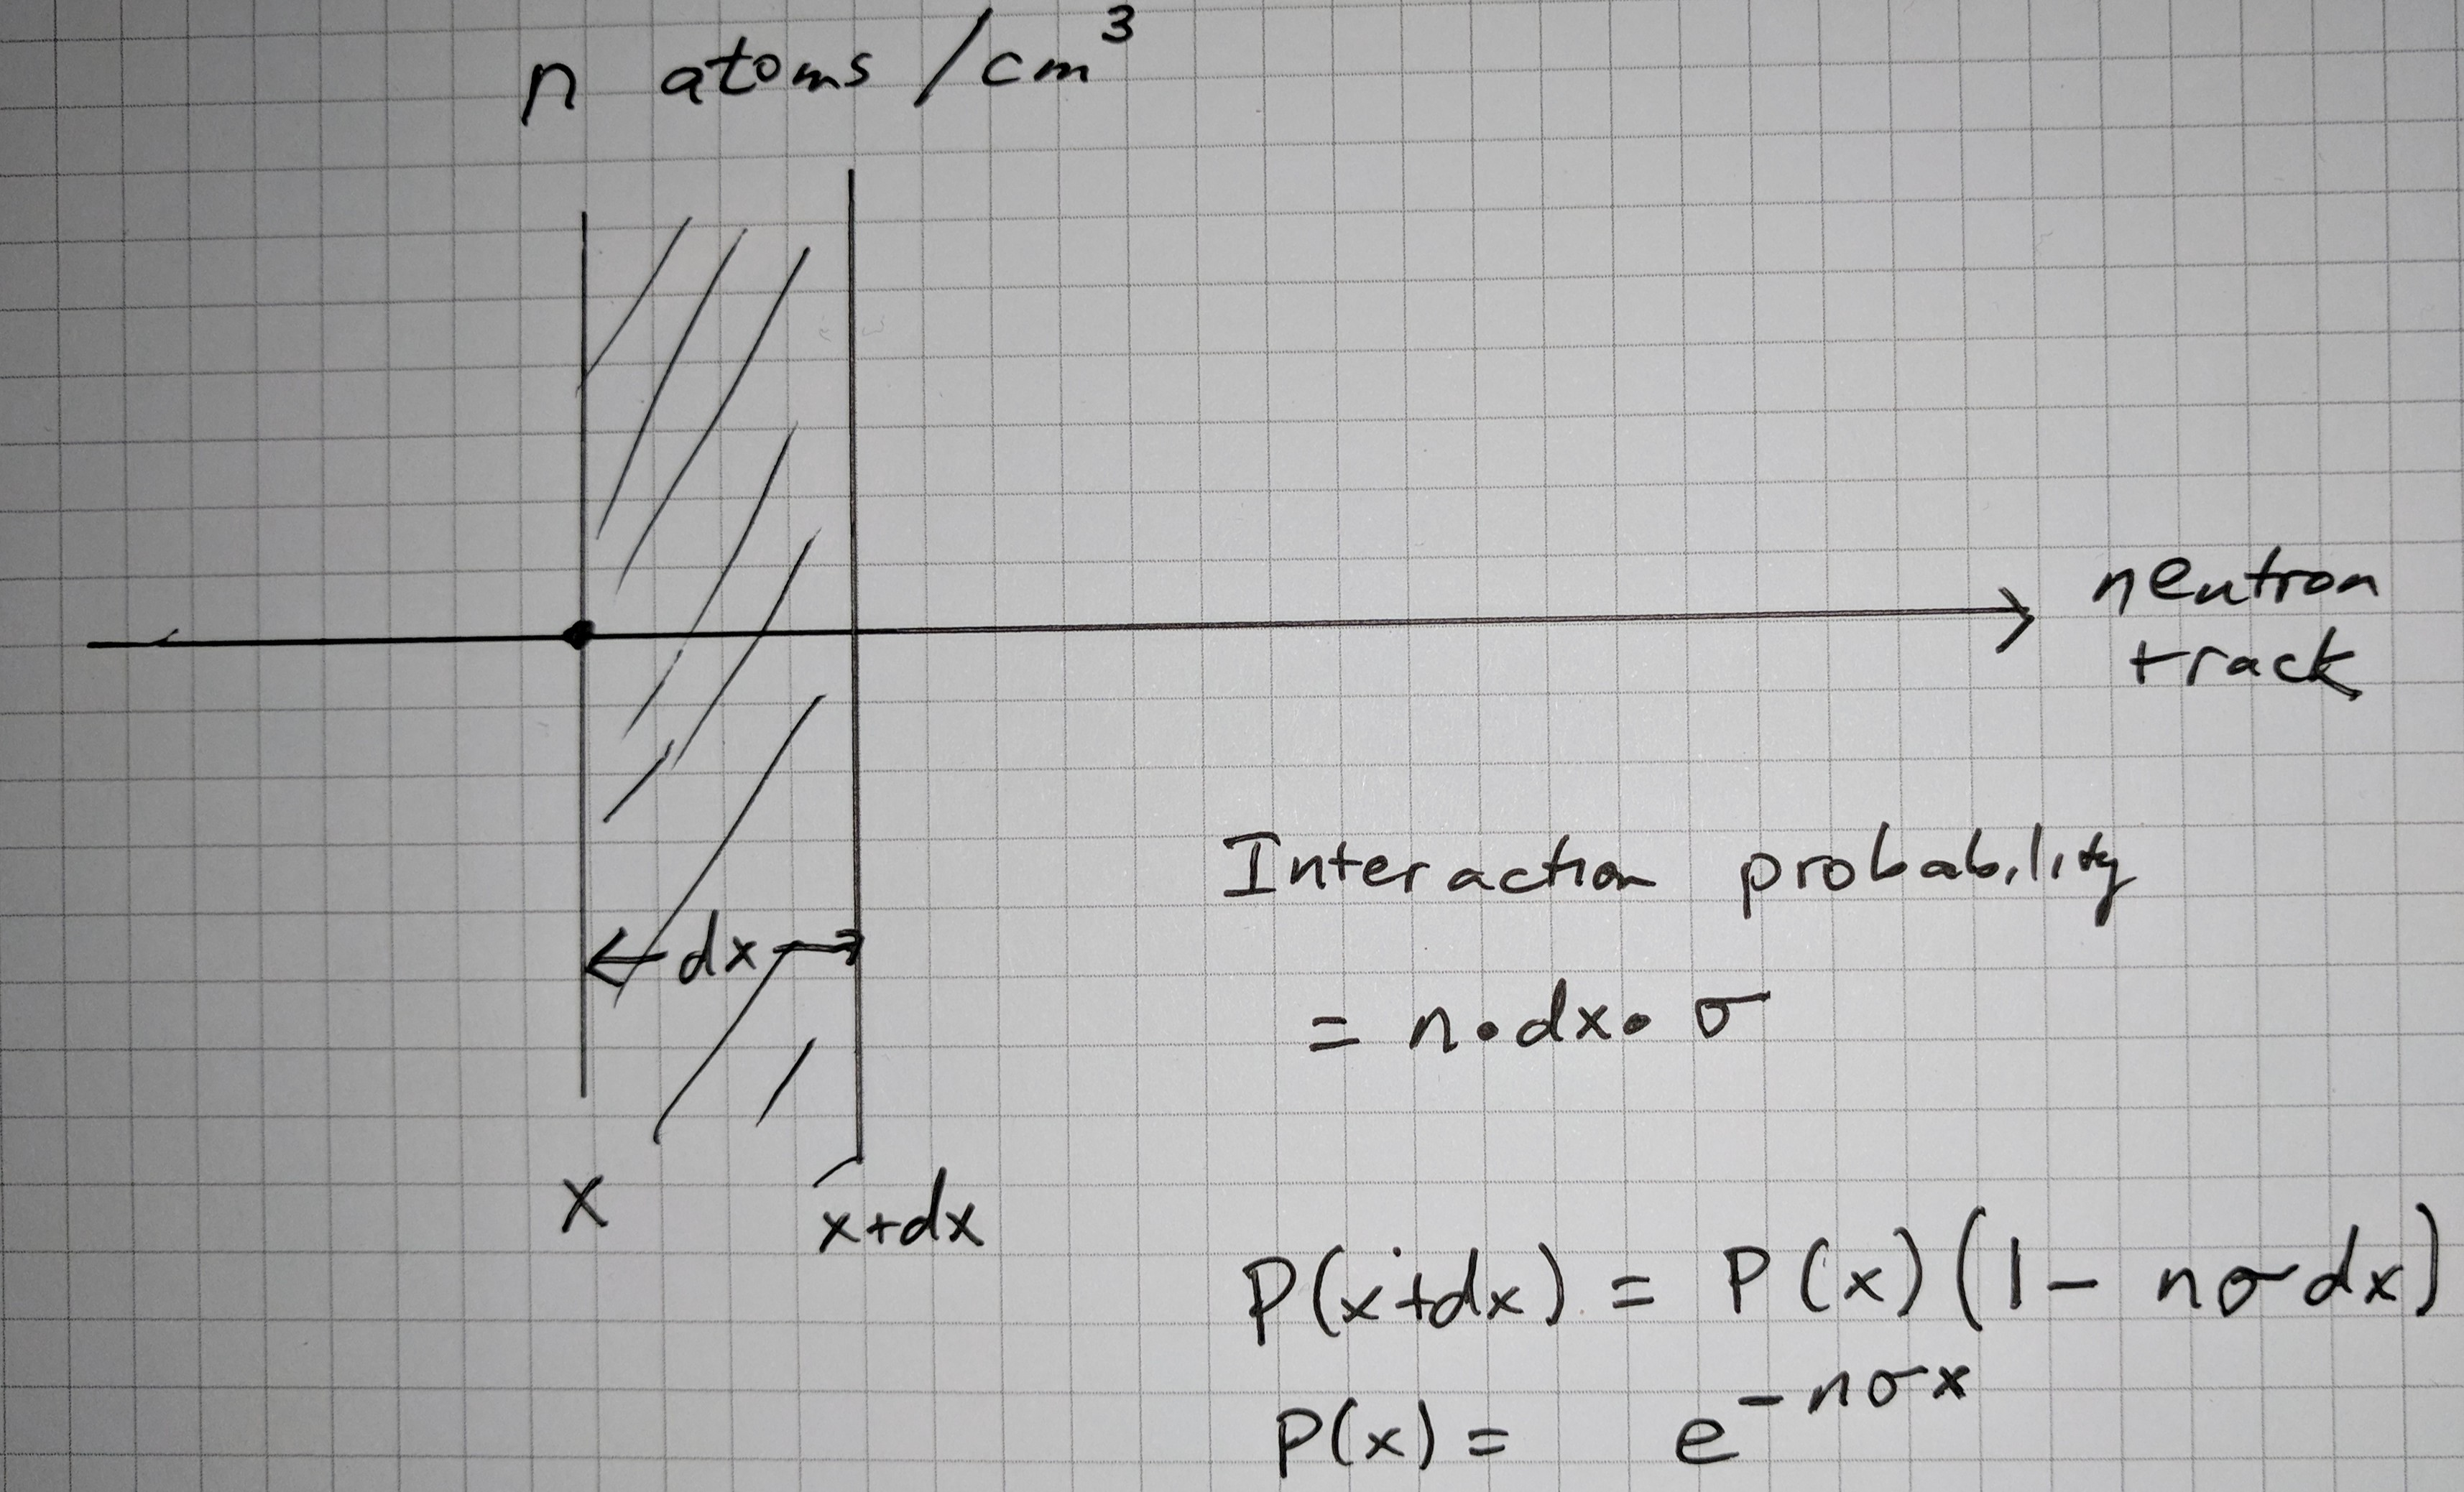
Note that $P(x)$ is the probability that the neutron will travel a distance x through a material without an interaction.  It is normalized properly $P(0)=1$.  If you double the distance you square the probability (ie.  if 90% of neutrons travel through a centimeter before interacting, 81% will travel through two).

For fission, we can look up all the relevent data on NNDC:  http://www.nndc.bnl.gov/sigma/index.jsp?as=235&lib=endfb7.1&nsub=10

We look at the neutron cross section to begin with: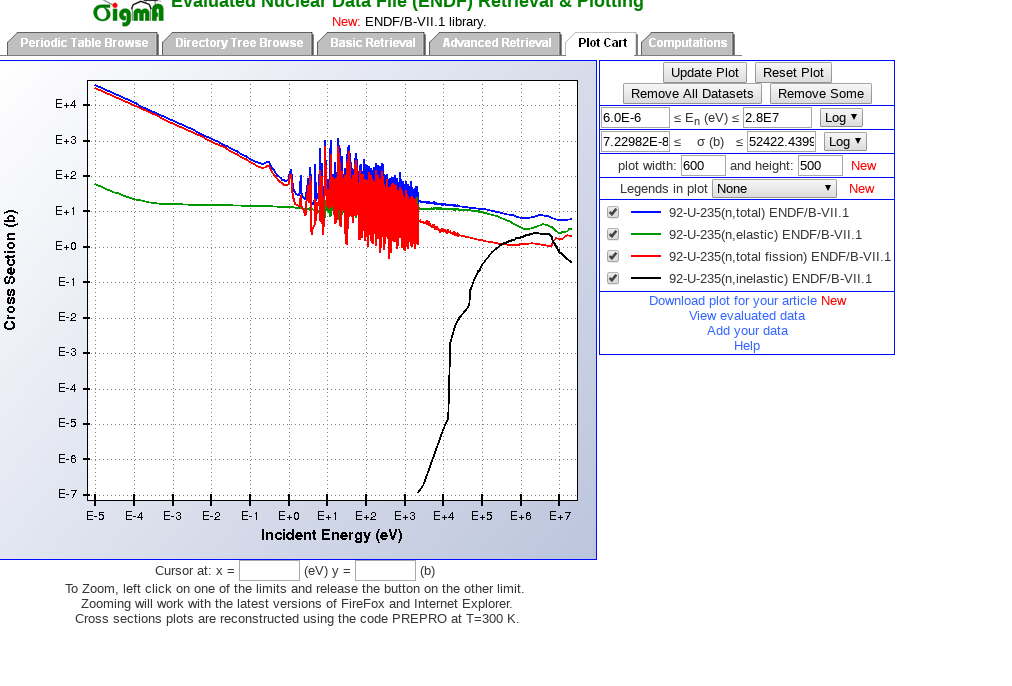


There are several cross sections here- which are essentially units of probability.  The *total* cross section represents the probability of any interaction, the *fission cross section* the probability that a neutron interaction will lead to fission, the *elastic cross section* the probability that the neutron scatters (and looses a little bit of energy to the Uranium recoil) and the *inelastic cross section* the probability that the neutron causes a change in the nuclear state.

We can safely ignore the inelastic cross section.

We will also need the average number of neutrons produced per fission, and their average energies:

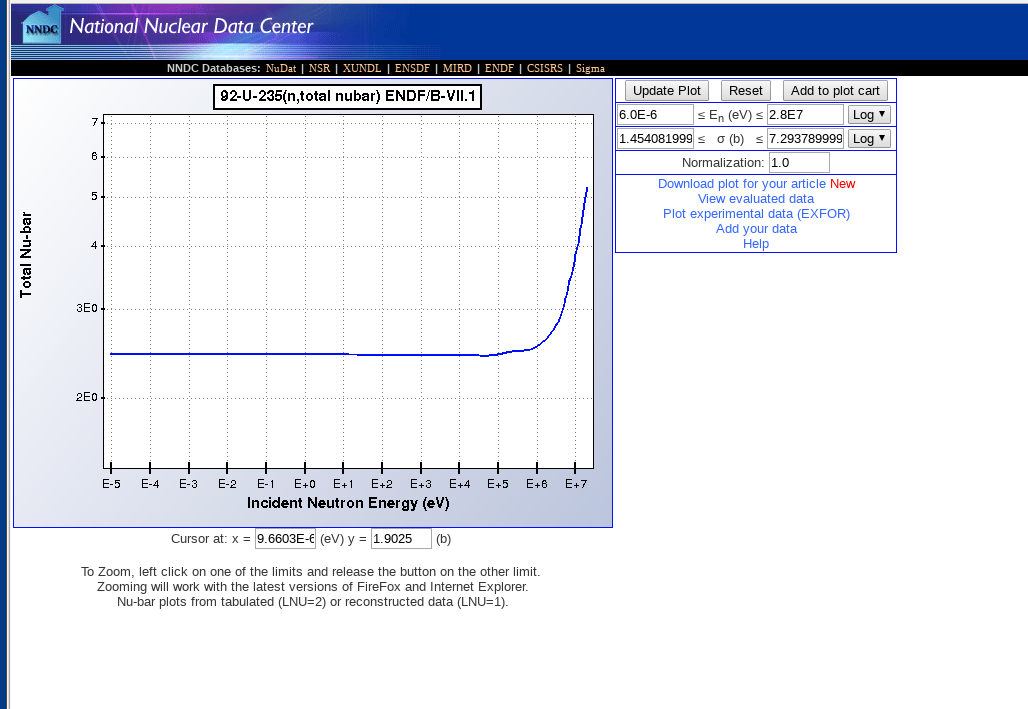

and the energy distribution of the neutrons:
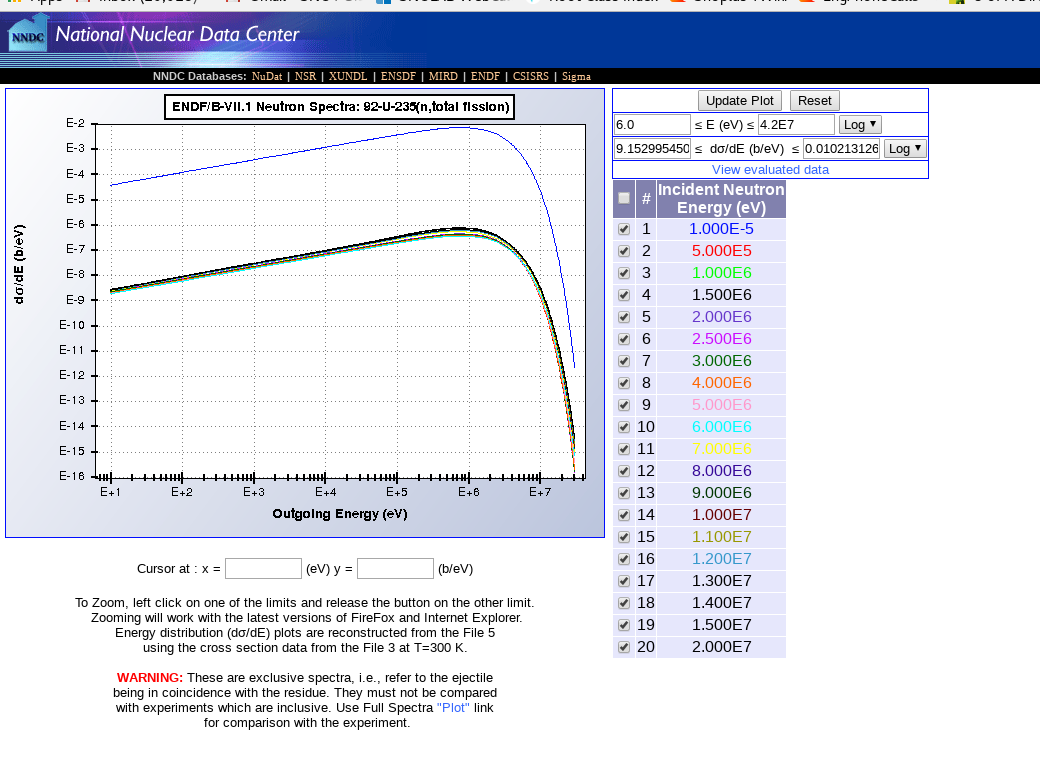

Our first step will be to download these data as tables, and read them into Python.  We will use linear interpolation for all distributions.  For this we use np.genfromtxt reader.  (I did find a few lines in the text files which have duplicate x values, and needed to be deleted in order for interpolation to work.)  I did try cubic spline interpolation, which results in significant discrepancies from the table values.  




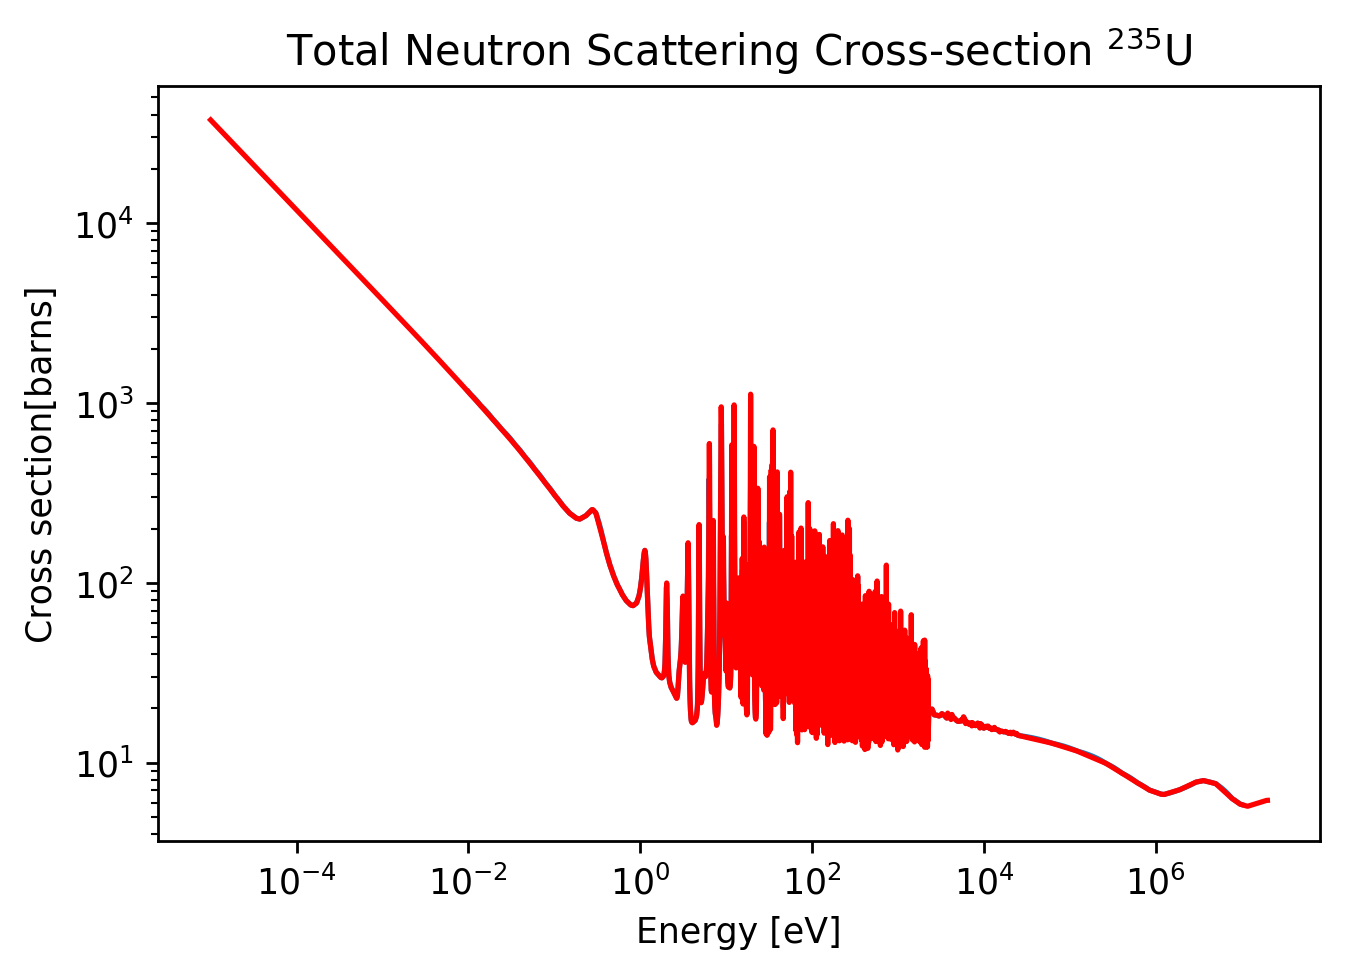

In [8]:
from scipy import interpolate
totalXdata=np.genfromtxt('TotalCrossSectionU235.txt',delimiter=',',skip_header=1)
totalX=interpolate.interp1d(totalXdata[:,0].reshape(-1),totalXdata[:,1].reshape(-1),kind='linear')

er=np.logspace(-2,7,1000)
plt.figure()
plt.plot(er,totalX(er))
plt.plot(totalXdata[:,0],totalXdata[:,1],'r')
plt.xscale('log')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Total Neutron Scattering Cross-section $^{235}$U')
plt.ylabel('Cross section[barns]')
plt.xlabel('Energy [eV]')


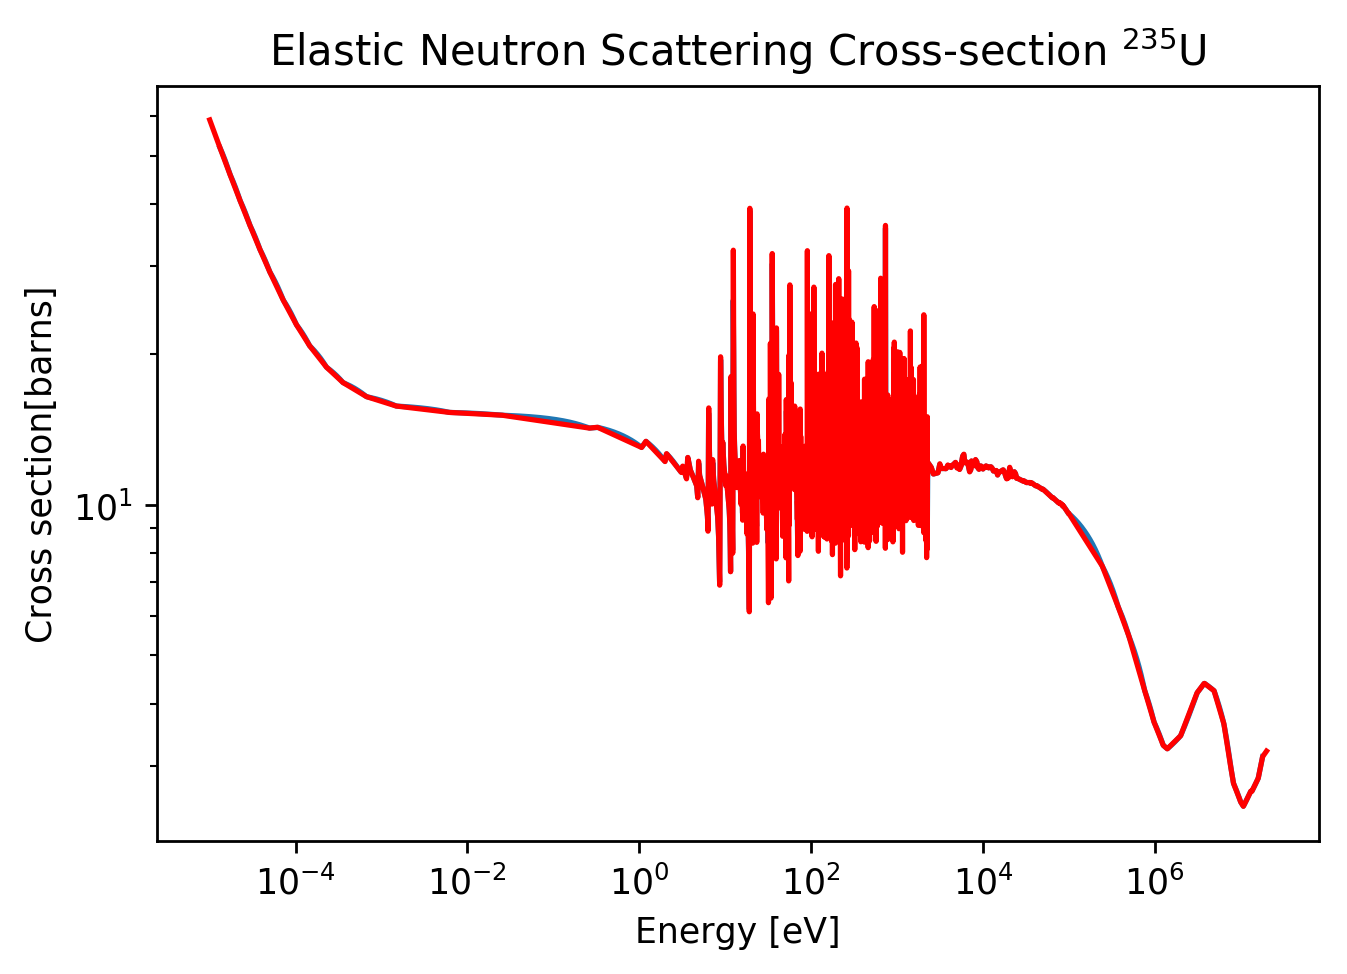

In [9]:
elasticXdata=np.genfromtxt('ElasticCrossSectionU235.txt',skip_header=1,delimiter=',')
#the following two lines elements where two subsequent entries have the same x value.  Spline can't interpolate those!
dd=np.where(elasticXdata[1:,0]<=elasticXdata[:-1,0])[0]
elasticXdata=np.delete(elasticXdata,dd,axis=0)
elasticX=interpolate.interp1d(elasticXdata[:,0].reshape(-1),elasticXdata[:,1].reshape(-1))
er2=np.logspace(np.log10(elasticXdata[1,0]),np.log10(elasticXdata[-2,0]),2000)
    
plt.figure()
plt.plot(er2,elasticX(er2))
plt.plot(elasticXdata[:,0],elasticXdata[:,1],'r')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Elastic Neutron Scattering Cross-section $^{235}$U')
plt.ylabel('Cross section[barns]')
plt.xlabel('Energy [eV]')


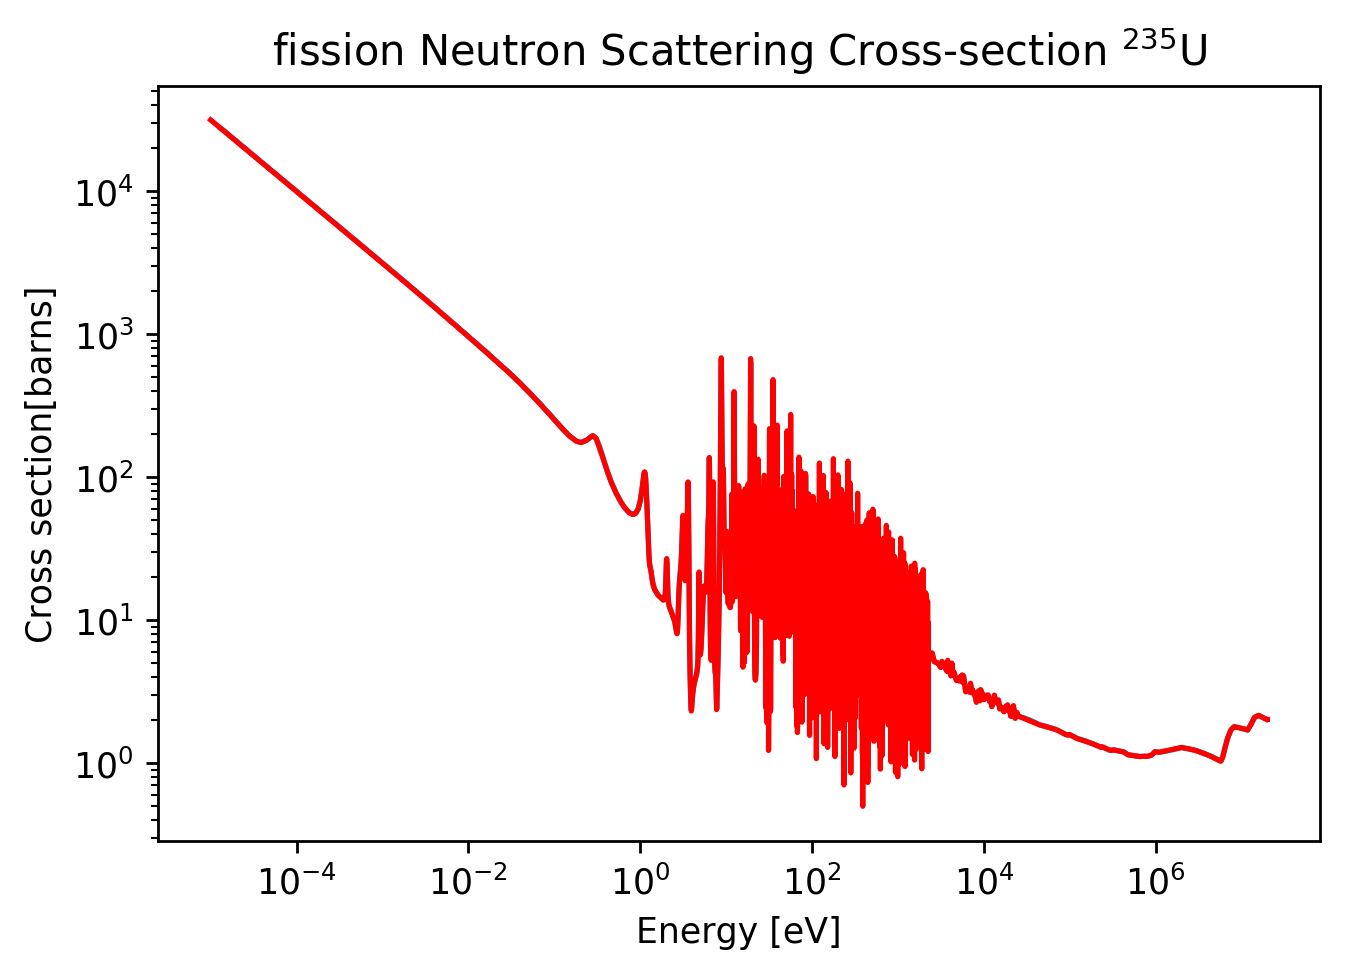

In [10]:
fissionXdata=np.genfromtxt('FissionCrossSectionU235.txt',skip_header=1,delimiter=',')
#the following two lines elements where two subsequent entries have the same x value.  Spline can't interpolate those!
dd=np.where(fissionXdata[1:,0]<=fissionXdata[:-1,0])[0]
fissionXdata=np.delete(fissionXdata,dd,axis=0)
fissionX=interpolate.interp1d(fissionXdata[:,0].reshape(-1),fissionXdata[:,1].reshape(-1))
er3=np.logspace(np.log10(fissionXdata[1,0]),np.log10(fissionXdata[-2,0]),2000)
    
plt.figure()
plt.plot(er3,fissionX(er3))
plt.plot(fissionXdata[:,0],fissionXdata[:,1],'r')
plt.xscale('log')
plt.yscale('log')
plt.title(r'fission Neutron Scattering Cross-section $^{235}$U')
plt.ylabel('Cross section[barns]')
plt.xlabel('Energy [eV]')


In [11]:
dd

array([ 9389, 13495, 13565])

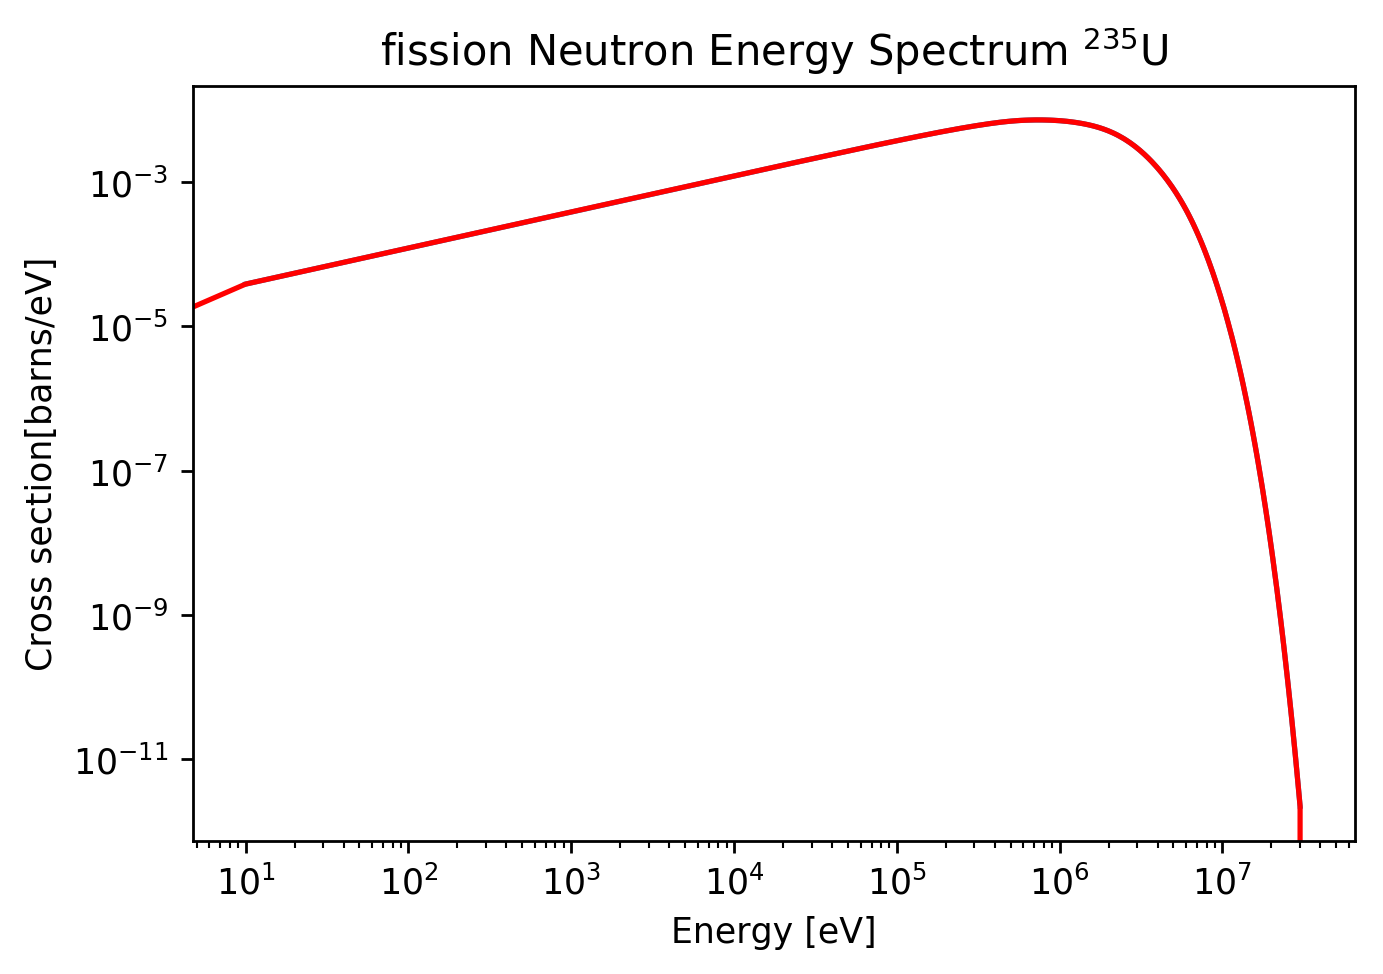

In [12]:
fissionEnergy=np.genfromtxt('FissionOutgoingEnergySpectraU235.txt',skip_header=5)
#the following two lines elements where two subsequent entries have the same x value.  Spline can't interpolate those!
#dd=np.where(fissionEnergy[1:,0]<=fissionEnergy[:-1,0])[0]
#fissionEnergy=np.delete(fissionEnergy,dd,axis=0)
fissionE=interpolate.interp1d(fissionEnergy[:,0].reshape(-1),fissionEnergy[:,1].reshape(-1))
er4=np.logspace(np.log10(fissionEnergy[1,0]),np.log10(fissionEnergy[-2,0]),2000)
    
plt.figure()
plt.plot(er4,fissionE(er4))
plt.plot(fissionEnergy[:,0],fissionEnergy[:,1],'r')
plt.xscale('log')
plt.yscale('log')
plt.title(r'fission Neutron Energy Spectrum $^{235}$U')
plt.ylabel('Cross section[barns/eV]')
plt.xlabel('Energy [eV]')


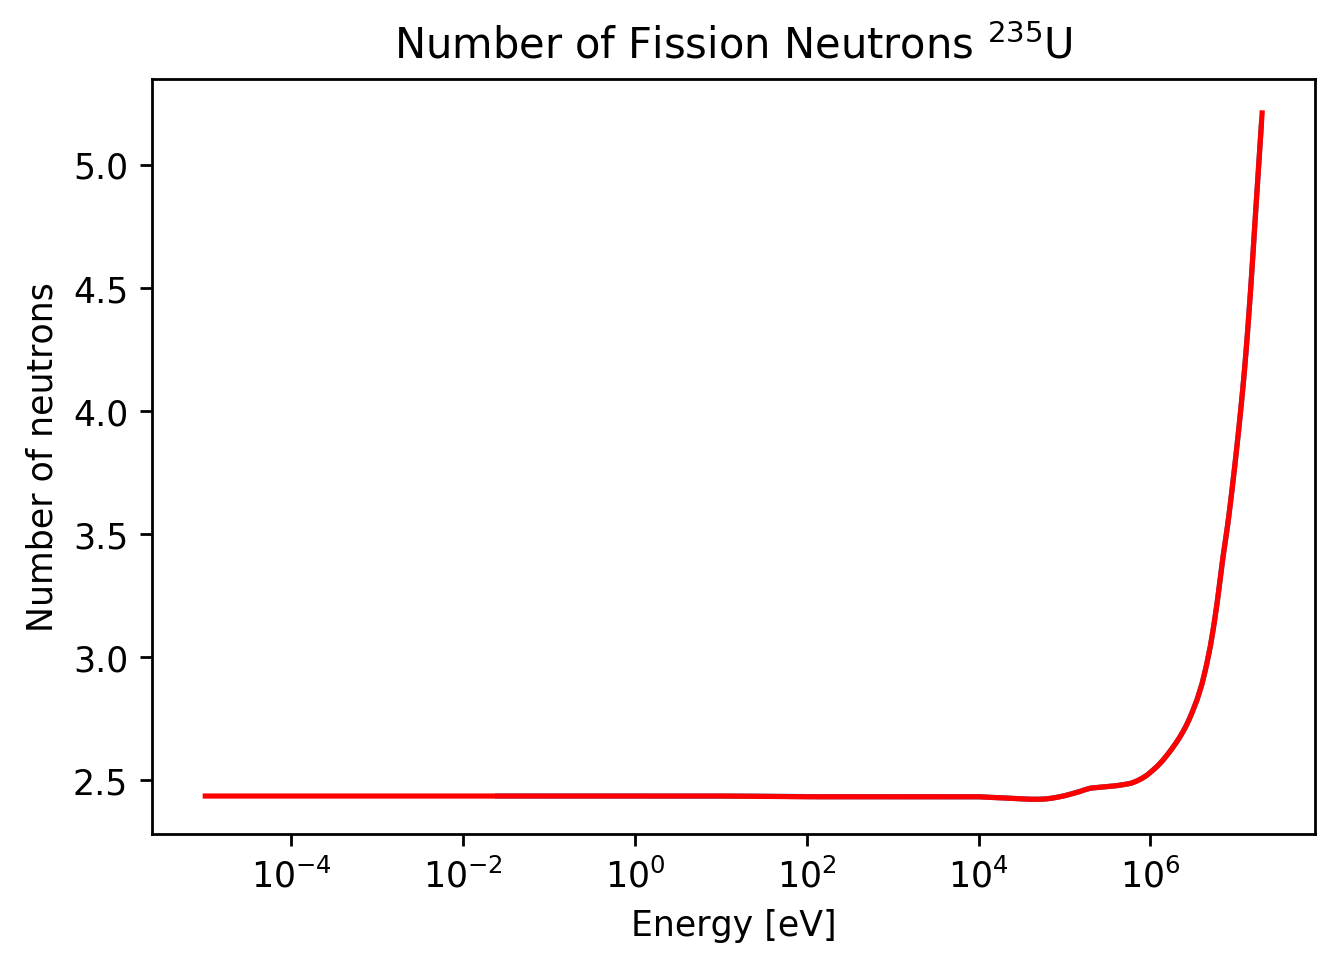

In [13]:
fissionN=np.genfromtxt('NumberNeutronsU235.txt',skip_header=1,delimiter=',')
#the following two lines elements where two subsequent entries have the same x value.  Spline can't interpolate those!
#dd=np.where(fissionN[1:,0]<=fissionN[:-1,0])[0]
#fissionN=np.delete(fissionN,dd,axis=0)
fissionNumber=interpolate.interp1d(fissionN[:,0].reshape(-1),fissionN[:,1].reshape(-1))
er5=np.logspace(np.log10(fissionN[1,0]),np.log10(fissionN[-2,0]),2000)
    
plt.figure()
plt.plot(er5,fissionNumber(er5))
plt.plot(fissionN[:,0],fissionN[:,1],'r')
plt.xscale('log')
plt.title(r'Number of Fission Neutrons $^{235}$U')
plt.ylabel('Number of neutrons')
plt.xlabel('Energy [eV]')


## The fission Monte Carlo

Now we have the basic data for $^{235}$U imported into python. 

We will assume that we have a sphere of $^{235}$U, with mass $M$ (that we will adjust).  

Our MC will proceed as follows:
1.  We start by generating a neutron at a random position inside the sphere, and generate its energy according to the fission neutron energy spectrum.  We choose its direction to be isotropic.  Throughout, we use the notation that $U(a,b)$ returns a flat distribution between a and b, and have the radius of the sphere as $r_s$.  
    -\begin{equation}\vec{r_0}=r_0(\sin\theta_0\cos\phi_0,\sin\theta_0\sin\phi_0,\cos\theta_0)\end{equation}
    -\begin{equation}r_0=r_sU^{1/3}(0,1)\end{equation}
    -\begin{equation}\theta_0=\cos^{-1}(U(-1,1))\end{equation}
    -\begin{equation}\phi_0=2\pi U(0,1)\end{equation}
    -note that to generate a random direction $\vec{n}$ we throw $\theta,\phi$ in exactly the same way, and have the magnitude of the direction vector set to 1
    -for the neutron energy spectrum, we generate neutrons by solving for the variable $E$ in the integral equation
    \begin{equation}\int_0^{E} E_f(x)dx=U(0,1)\int_0^{\infty} E_f(x)dx\end{equation}.  Here $E_f$ is the distribution given by fissionE in the code above.  From the energy we calculate velocity $v$.
2.  We calculate the distance it can travel until a) it hits the outside of the sphere (which is just geometry) b) distance to the next interaction (based on the *total* cross section.  If a is less than b, the neutron escapes, and we go back to (1)
    -The geometry calculation is $\vec{r}=\vec{r_0}+vt\vec{n}$.  To find the intersection with the sphere we solve $\vec{r}^2=r_s^2$
    - We generate the distance to the next interaction by using the same exponential random number generation as we did for the Radon decay example.  
3. If the neutron interacts, we pick a random number to describe its interaction: either elastic scattering or fission
    -the probability of fission, $P_f(E)=\frac{\sigma_f(E)}{\sigma_f(E)+\sigma_e(E)}$, where $\sigma_f, \sigma_e$ are the fission and elastic scattering cross sections.
4. For elastic scattering, we calculate the kinetic energy loss of the neutron
    -for this we will calculate the recoil energy of the uranium and subtract it from the neutron energy.  We do this in the center of mass.  
5. For fission, we generate a random number to throw the number of neutrons generated.  Here we will solve the same type of equation as we did for the energy of the neutrons
6. For each generated neutron we decide on an energy, according to the energy spectrum of fission neutrons and generate a random direction.  

and we continue until we have generated 1 Million neutrons, say.  We do need to think about organization of the code-- if you think about a chain reaction what is the reasonable way to follow neutrons and their fission neutrons afterwards?

What we will do is keep track of the time when the neutron "disappears"-- either by leaving the sphere or by fission.  For scattering events we will just keep following the neutron.  

We will keep track of the neutron position, energy, time.

For validation we will histogram each distribution that we generate.  We will also build in some test functions in various codes.


## Code Organization:  Classes

This code is sufficiently complicated that we don't want to write it all as a single piece of code that we run inside the jupyter notebook.  Instead, we will arrange the code in terms of *classes*, which are blocks of code that contain both the data and the functions that operate on the data.  Part of this is that we want to be able to expand the MC to include other materials- such as $^{238}$U or heavy water; and we want to be able to change from a spherical geometry to more complicated geometries.  To accomodate that we will organize the program into three main sections:
1.  Materials (which contain the information about the various cross sections and interactions that neutrons do. Methods will include:
    1.  fractions(energy), which will calculate the distance to the next interaction, based on the total cross section.  It returns the interaction length, the elastic fraction and the fission fraction
    2.  interaction(energy): calls fractions; throws a random number and decides which interaction to do.  For elastic scattering returns (True, interaction length, (cosTheta, cmvelocity/velocity).  For fissions returns (False, interaction length, (daughter energies).  
2.  Geometries (which contain the information about the shapes and size of parts of the code.  
    1.  NextInteraction(neutron) returns the time of the next intersection.  Determines wheter the neutron will leave the geometry or not before scattering.  Returns the time to the next interaction, if the scattering is elastic, and the output of Materials.interaction
    2.  This also contains the routines that throw the position and direction of neutrons.  The energy needs to be generated by the Material class, but this will call that as well.
3.  Neutrons (which contain the information about energy, direction, time of the neutron.  There is a list of neutrons, binned by time.  
    
    
Our main program will start by creating a number of neutrons at random times and random positions. It will maintain a list of neutrons, binned according to neutron stopping time.  It will then loop through the stopping times, processing all the neutrons.  


In [14]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure',dpi=250)



The materials class will need to generate scatters, and secondary particles for a particular material.  We will get to that, but first we need to go through and see how we will generate angular distributions and energy distributions.

## Aside:  Setting up the tools for the MC code

We are going to need to read in tables, and then generate distributions from those tables.  So we will take a significant aside to look at the code for reading the data, throwing distributions, and some neutron scattering code.  

### Angular Distributions from NNDC (ENDF database)
Angular distributions are described in the ENDF102 document (https://www.bnl.gov/isd/documents/70393.pdf), chapter 4.

For two body interactions, we know Quantum Mechanics breaks up into solutions of different angular momentum- each angular momentum corresponds to a different Legendre polynomial.  Thus, the coefficients in the data tables consist of coefficients of Legendre Polynomials.

This makes our lives easier, because numpy has legendre polynomials built in the polynomial.legendre class.  In order to generate angular distributions from elastic scattering, we will generate the probability distribution function:
\begin{equation}f(\mu,E)=\sum_{l=0}^N\frac{2l+1}{2}a_i(E)P_l(\mu)\end{equation}

Here $\mu=\cos\theta$.

For throwing points according to the distribution, we need to integrate to find the probability $P(\mu)$- that is, what is the integrated probability distribution:
\begin{equation}P(\mu,E)=\int_{-1}^{\mu}f(\mu',E)d\mu'\end{equation}
The polynomial class has built in integration that gives us a new legendre polynomial as the integral of the previous one.

To generate $\mu$ we pick a random number $R$ and solve:
\begin{equation}P(\mu,E)=R\end{equation}

The ENDF documentation says that we can linearly interpolate in E.   For now, we will ignore that, and just "go to the nearest" tabulated polynomial to get our angular distributions.   


In [15]:
energyList=[]
legendreList=[]
k=0
lfactor=np.arange(0,30)+0.5
with open('angularDistU235Elastic.txt', 'r') as f:
    for line in f:
        if 'Angular' in line:
            pass
        elif 'eV  Coefficients' in line:
            pass
        elif '-----' in line:
            pass
        elif len(line)==1:
            pass
        else:
            print(len(line),line[0:-1])
            if not line[0:10].isspace():
                energy=float(line[0:10]+'e'+line[10:12])
                energyList.append(energy)
                if len(energyList)>1:
                    leg=np.polynomial.legendre.Legendre(np.array(l)*lfactor[:len(l)])
                    legendreList.append(leg)
                    k=k+1
                l=[1.0]
            for i in range(13,79,11):
                if not(line[i:i+9].isspace()):
                    coeff=float(line[i:i+9]+'e'+line[i+9:i+11])
                    l.append(coeff)
                                                       

80   1.000000-5  0.000000+0 0.000000+0                                            
80   1.000000+3  1.154000-3 1.763000-6-3.747000-7-1.785000-6                      
80   5.000000+3  6.098000-3 3.974000-5-1.186000-8 4.078000-7                      
80   1.000000+4  1.259000-2 1.521000-4 1.567000-6 1.192000-7                      
80   5.000000+4  6.545000-2 3.277000-3 6.037000-5 2.284000-6 1.028000-6 0.000000+0
80   1.000000+5  1.249000-1 1.131000-2 4.680000-4 7.512000-6-1.050000-5 0.000000+0
80   2.000000+5  1.962000-1 3.576000-2 4.635000-3 3.901000-4-5.652000-6-3.807000-6
80   3.000000+5  2.922000-1 6.844000-2 1.030000-2 9.190000-4 1.360000-5 1.290000-5
80   4.000000+5  3.372000-1 9.900000-2 2.300000-2 3.170000-3 3.833000-5 1.141000-5
80               3.487000-6 0.000000+0                                            
80   5.000000+5  3.929000-1 1.375000-1 3.917000-2 6.045000-3 7.522000-5 4.340000-6
80              -1.453000-5 0.000000+0                                            
80  

### Throwing and validating the angular distribution
We now define the P function and generate events.  We start by using the builtin legendre polynomial integration and root finding methods and generate a milltion events.  

To validate the code, we compare the histograms of generated data with the input probability distributions.  
Pick the 30th entry in the lists:

Generating angular distribution for energy 9000000.000000 eV
0 0.809944537827
1000 0.995123862486
2000 0.910315252237
3000 0.946199401432
4000 0.928180894757
5000 0.960220258607
6000 0.990624290673
7000 0.961399658389
8000 0.999735190237
9000 0.987014676493
time is 4.8970723152160645


(array([  4.00350417e-02,   1.00087604e-02,   0.00000000e+00,
          3.00262813e-02,   0.00000000e+00,   4.00350417e-02,
          2.00175209e-02,   3.00262813e-02,   1.00087604e-02,
          1.00087604e-02,   3.00262813e-02,   8.00700834e-02,
          7.00613230e-02,   1.00087604e-02,   3.00262813e-02,
          5.00438021e-02,   4.00350417e-02,   2.00175209e-02,
          4.00350417e-02,   0.00000000e+00,   1.00087604e-02,
          4.00350417e-02,   2.00175209e-02,   0.00000000e+00,
          1.00087604e-02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00087604e-02,   2.00175209e-02,
          2.00175209e-02,   0.00000000e+00,   2.00175209e-02,
          3.00262813e-02,   0.00000000e+00,   0.00000000e+00,
          2.00175209e-02,   3.00262813e-02,   2.00175209e-02,
          2.00175209e-02,   3.00262813e-02,   7.00613230e-02,
          5.00438021e-02,   4.00350417e-02,   6.00525626e-02,
          5.00438021e-02,   5.00438021e-02,   2.00175209e-02,
        

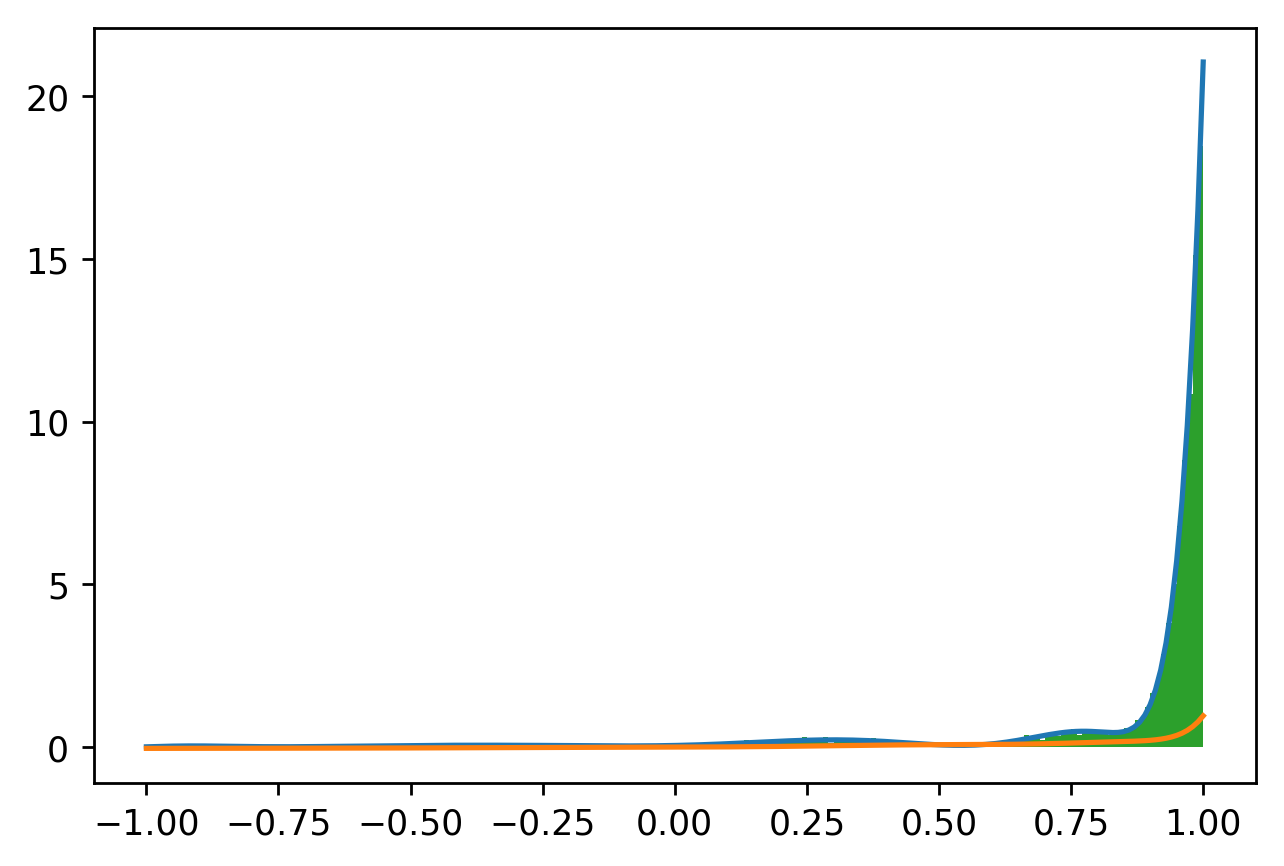

In [16]:

import time
def throw(r):
    '''Take a vector of random numbers r and generate events according to the legendreIntegral(x)=r'''
    retval=np.empty(len(r))
    for i in np.arange(0,len(r)):
        rr=r[i]
        ll=legendreIntegral-rr
        roots=ll.roots()
        realroots=roots[np.where(np.isreal(roots))].real
        retval[i]=realroots[np.where(abs(realroots)<=1)]
        if i%1000 ==0:
            print(i,retval[i])
    return retval

N=10000
idist=30
print('Generating angular distribution for energy %f eV'%energyList[idist])
leg=legendreList[idist]
leg0=leg.integ()  # integral from zero
legendreIntegral=leg0-leg0(-1) #integral from -1
start=time.time()
dist=throw(np.random.rand(N))
end=time.time()
print('time is',end-start)
plt.figure()
xx=np.linspace(-1,1,200)
plt.plot(xx,leg(xx))
#plt.plot(xx,legin(xx))
plt.plot(xx,leg0(xx))
plt.hist(dist,200,normed=True)
#plt.ylim(-0.2,1)


This is pretty slow, so we use a Chebyshev interpolation to speed it up.  

0 0.9999970682
time is 0.8283319473266602


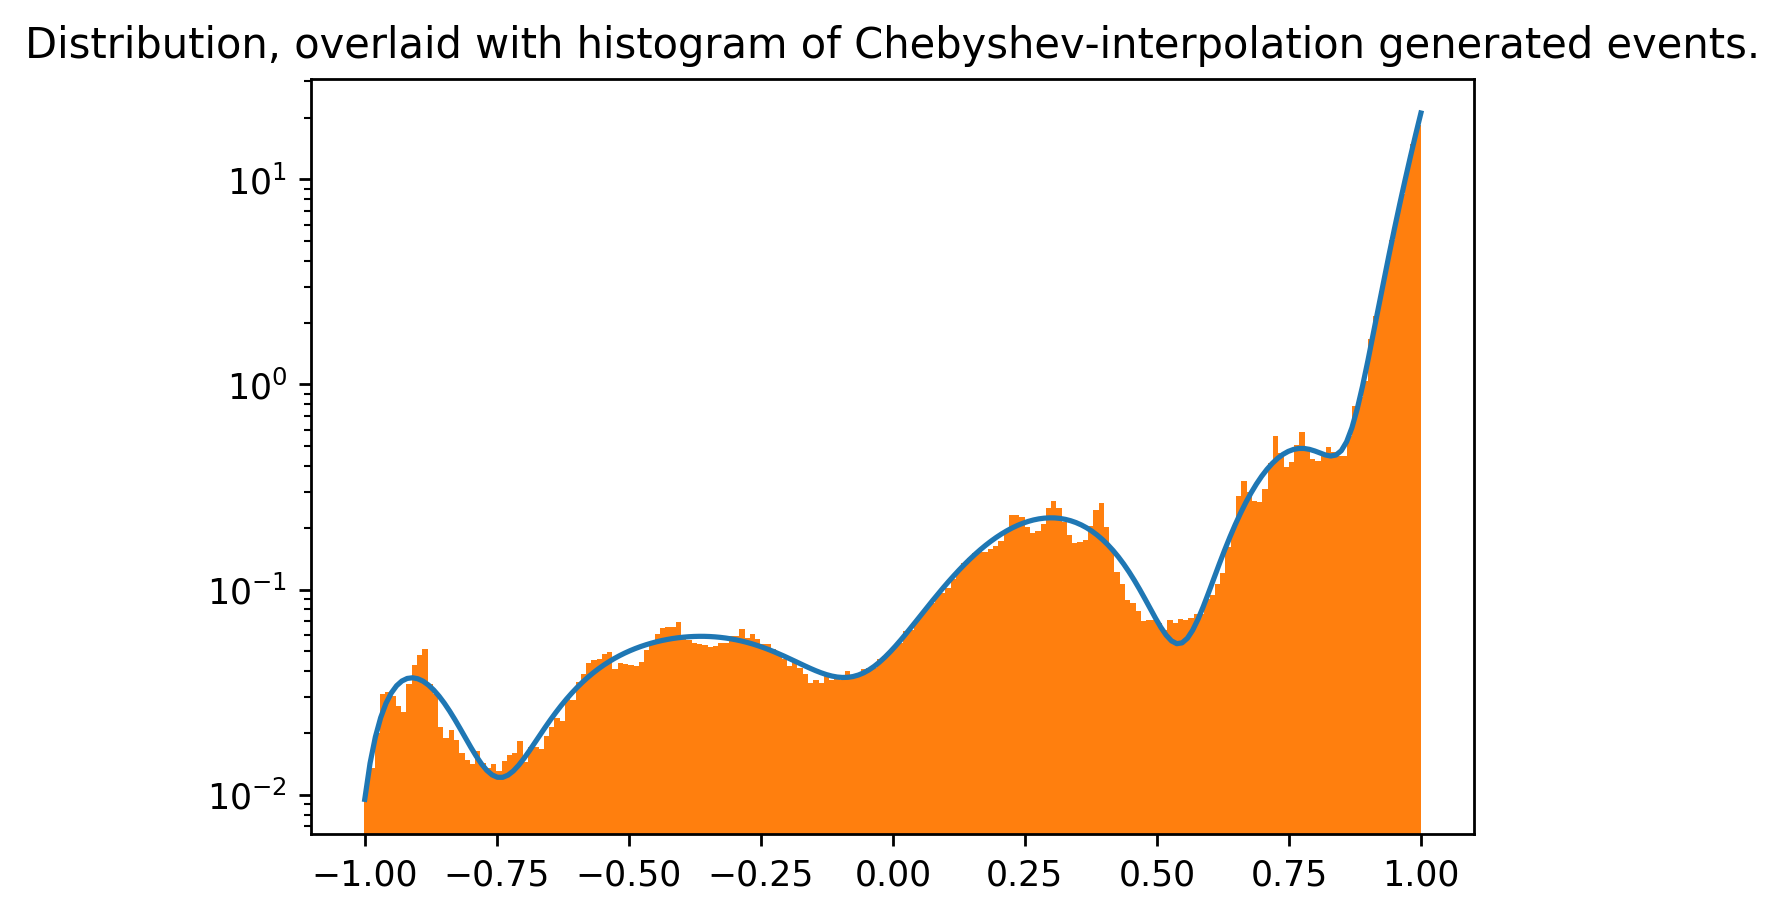

In [17]:
def ChebyshevCoefficients(func,a,b,n):
    '''Evaluate n chebyshev coefficients for func evaluated between a and b;  based on NR 5.8.7'''
    rnge=0.5*(b-a)  
    average=0.5*(b+a)
    x=rnge*np.cos((np.arange(0,n)+0.5)*np.pi/n)+average  #maps from -1 to 1 onto a-b
    v=func(x).reshape(1,n)  #row array of function values
    A=np.cos(np.pi/n*np.arange(0,n)*((np.arange(0,n)+0.5)).reshape(n,1))
    C=np.dot(v,A)*2/n 
    return C.reshape(-1)
    
    
def ChebEval(x,c,a,b):
    '''Evaluate a chebyshev series c(x), for the rnge a-b'''
    rnge=0.5*(b-a)
    average=0.5*(a+b)
    mapped=(x-average)/rnge
    return np.polynomial.chebyshev.chebval(mapped,c)-c[0]/2
    

ch=ChebyshevCoefficients(throw,0,1,100)

N=1000000
start=time.time()
dist2=ChebEval(np.random.rand(N),ch,0,1)
end=time.time()
print('time is',end-start)
plt.figure()
plt.plot(xx,leg(xx))
plt.hist(dist2,200,normed=True)
plt.yscale('log')
plt.title("Distribution, overlaid with histogram of Chebyshev-interpolation generated events.")

Much faster, but even with 100th degree polynomial, note quite identical to the initial distribution.  This would probably be fine, but we would have the worry in the back of our minds that the distribution is a little wrong.

There is another facility- the legendre.linspace that returns equally spaced coordinates.  Let's use that and interpolate:


time= 0.11304807662963867


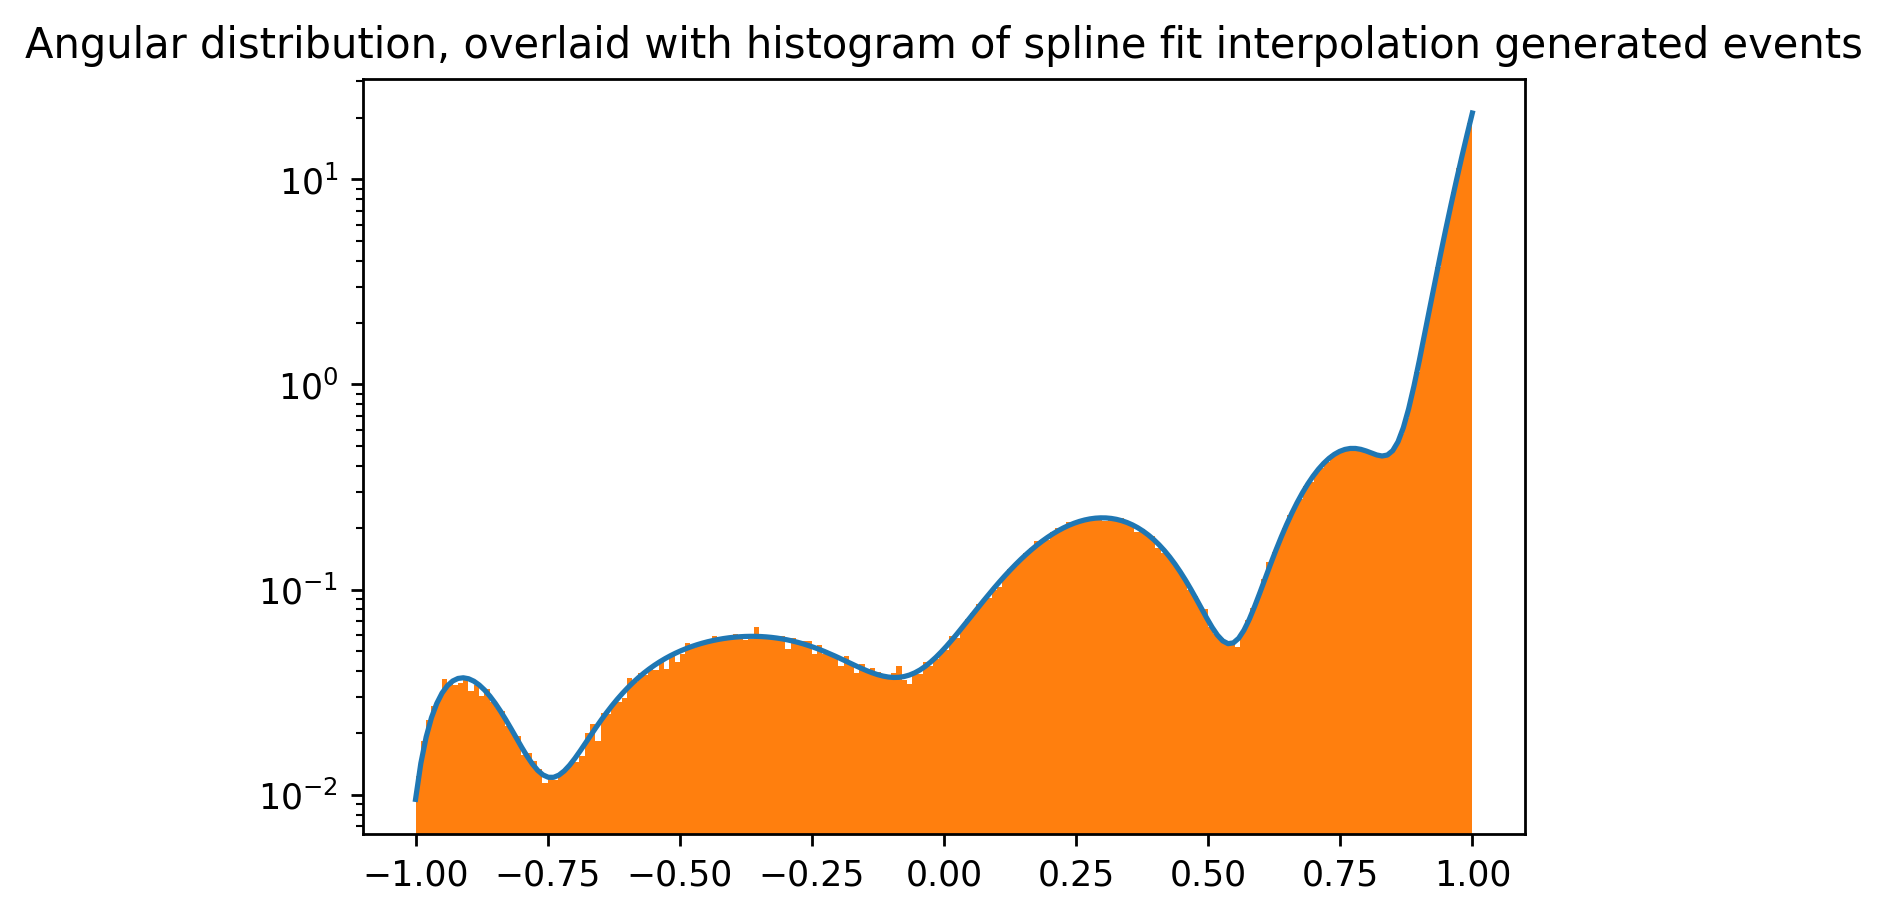

In [18]:
xv=legendreIntegral.linspace(200)
from scipy.interpolate import interp1d
intLeg=interp1d(xv[1],xv[0],kind='cubic')
start=time.time()
dist3=intLeg(np.random.rand(N))
end=time.time()
print('time=',end-start)
plt.plot(xx,leg(xx))
plt.hist(dist3,200,normed=True)
plt.yscale('log')
plt.title('Angular distribution, overlaid with histogram of spline fit interpolation generated events')


This is faster and more accurate.  So we will stick with it!

We go through and generate all the distributions in this way.  


In [19]:
throwAngles=[]
for leg in legendreList:
    leg0=leg.integ()  # integral from zero
    legendreIntegral=leg0-leg0(-1) #integral from -1xv=legendreIntegral.linspace(200)
    xv=legendreIntegral.linspace(200)
    intLeg=interp1d(xv[1],xv[0],kind='cubic')
    throwAngles.append(intLeg)

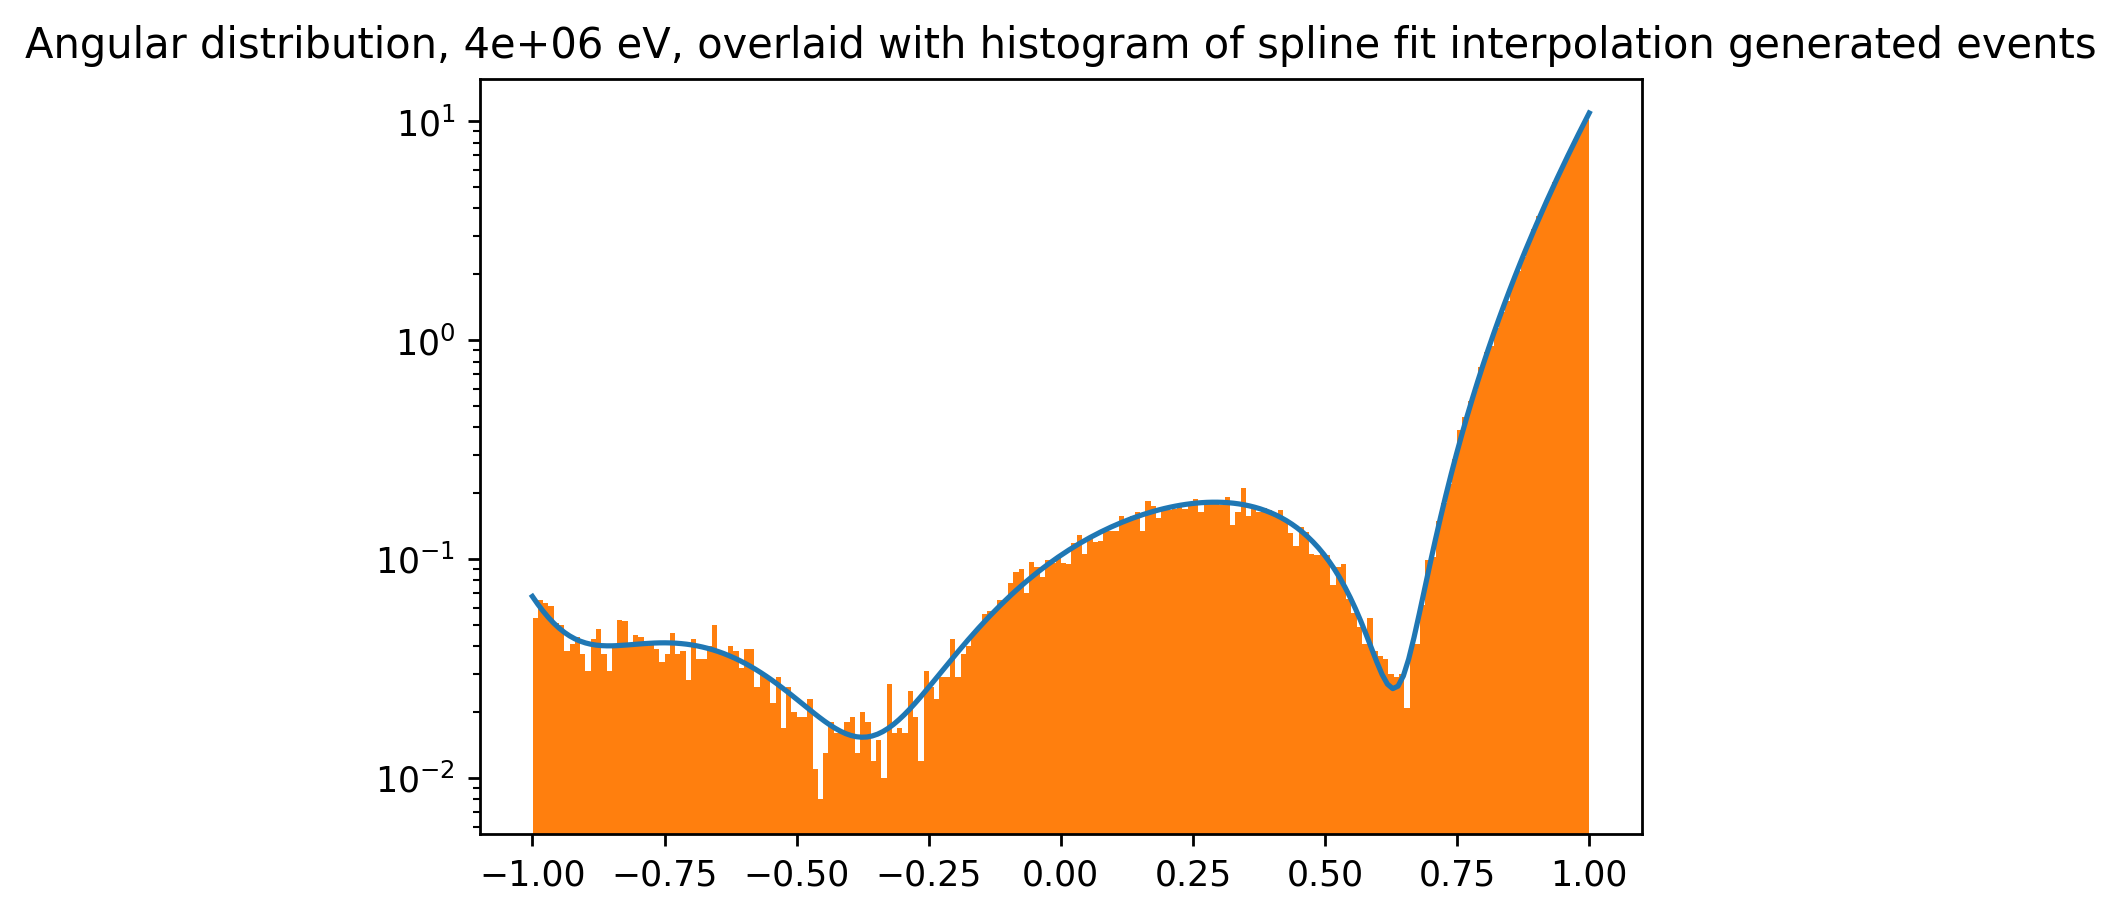

In [20]:
#validate.  Try this for low entry numbers.  What is happening?
entry=20
N=100000
dist4=throwAngles[entry](np.random.rand(N))

plt.figure()
plt.plot(xx,legendreList[entry](xx))
plt.hist(dist4,200,normed=True)
plt.yscale('log')
plt.title('Angular distribution, %g eV, overlaid with histogram of spline fit interpolation generated events'%energyList[entry])



Fission neutrons, and inelastic scattered neutrons will be calculated as isotropic.  This is close to correct.  

### Throwing the neutron energy spectrum

We already read in the neutron energy spectrum, which we replot below.  While it is useful to look at this distribution, the log-scale on the x-axis makes it a little difficult to get a good intuition of the probability distribution.  The y-axis is in units of barns/eV.  

We will also replot it on a linear scale. 


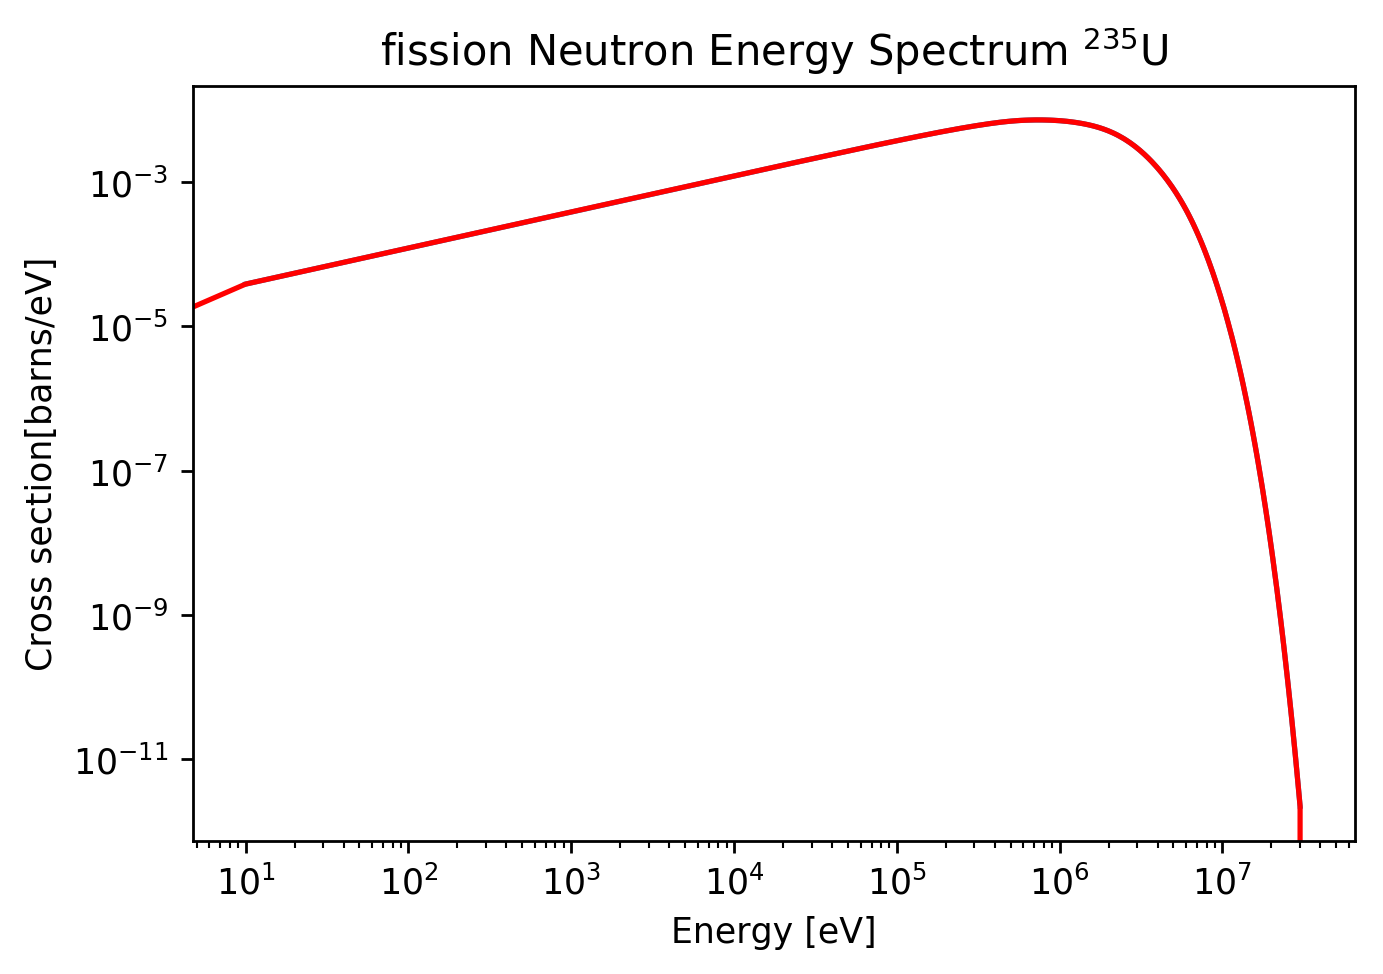

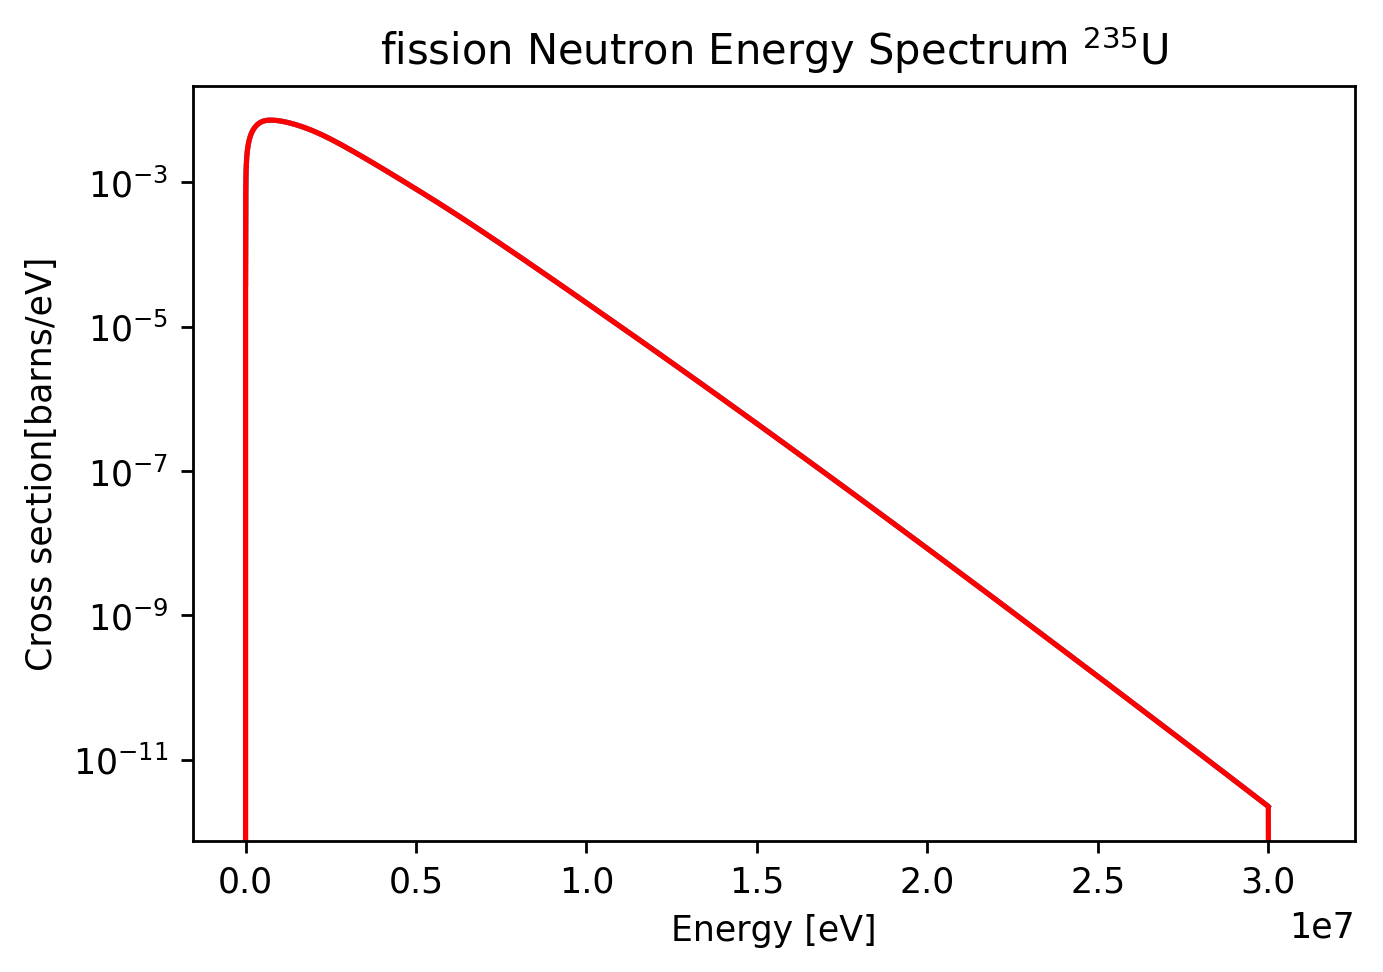

In [21]:
#fissionEnergy=np.genfromtxt('FissionOutgoingEnergySpectraU235.txt',skip_header=5)
#the following two lines elements where two subsequent entries have the same x value.  Spline can't interpolate those!
#dd=np.where(fissionEnergy[1:,0]<=fissionEnergy[:-1,0])[0]
#fissionEnergy=np.delete(fissionEnergy,dd,axis=0)
#fissionE=interpolate.interp1d(fissionEnergy[:,0].reshape(-1),fissionEnergy[:,1].reshape(-1))
#er4=np.logspace(np.log10(fissionEnergy[1,0]),np.log10(fissionEnergy[-2,0]),2000)

plt.figure()
plt.plot(er4,fissionE(er4))
plt.plot(fissionEnergy[:,0],fissionEnergy[:,1],'r')
plt.xscale('log')
plt.yscale('log')
plt.title(r'fission Neutron Energy Spectrum $^{235}$U')
plt.ylabel('Cross section[barns/eV]')
plt.xlabel('Energy [eV]')

#on a linear scale
er5=np.linspace(fissionEnergy[1,0],fissionEnergy[-2,0],2000)
plt.figure()
plt.plot(er5,fissionE(er5))
plt.plot(fissionEnergy[:,0],fissionEnergy[:,1],'r')
plt.yscale('log')
plt.title(r'fission Neutron Energy Spectrum $^{235}$U')
plt.ylabel('Cross section[barns/eV]')
plt.xlabel('Energy [eV]')



dd

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


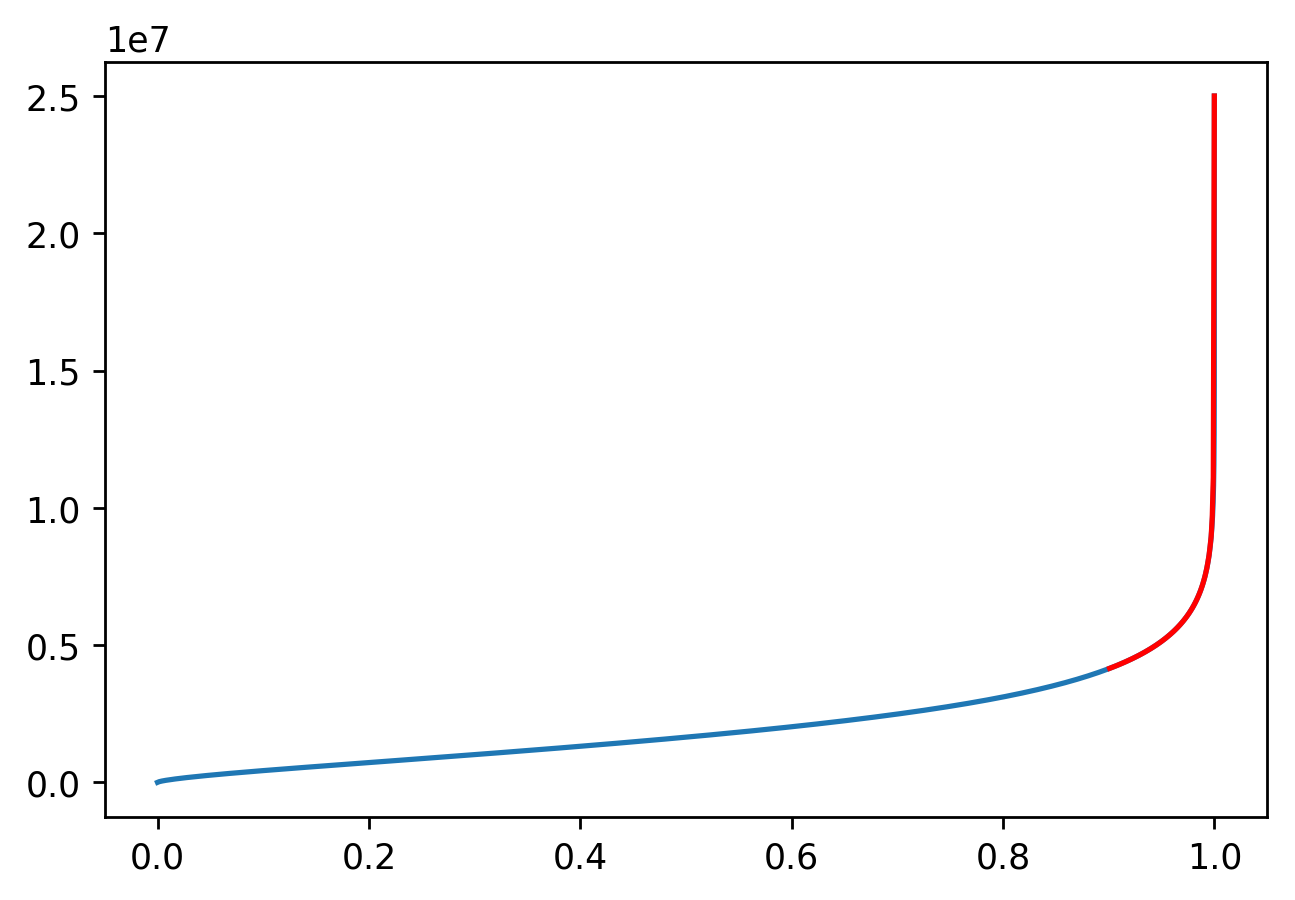

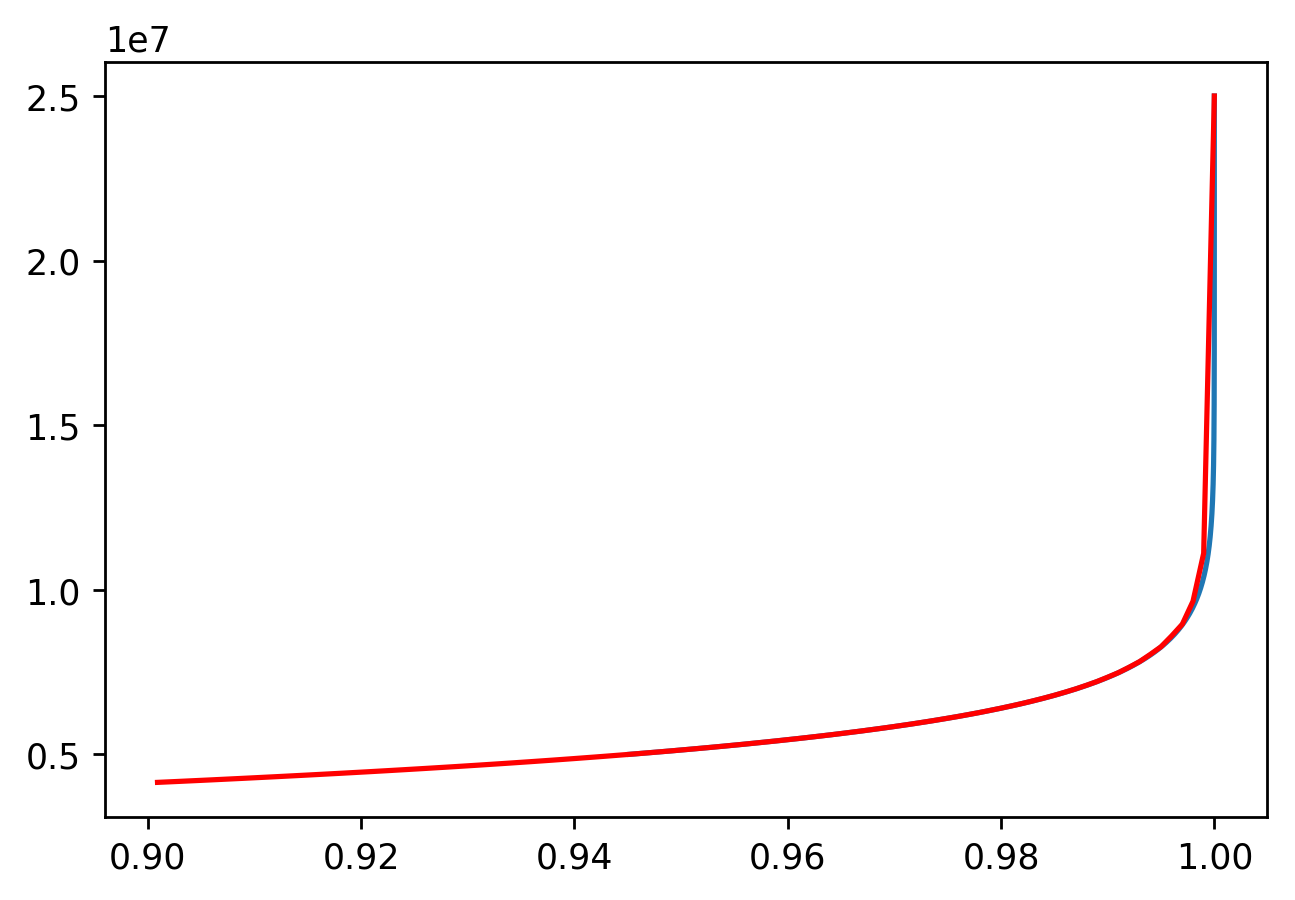

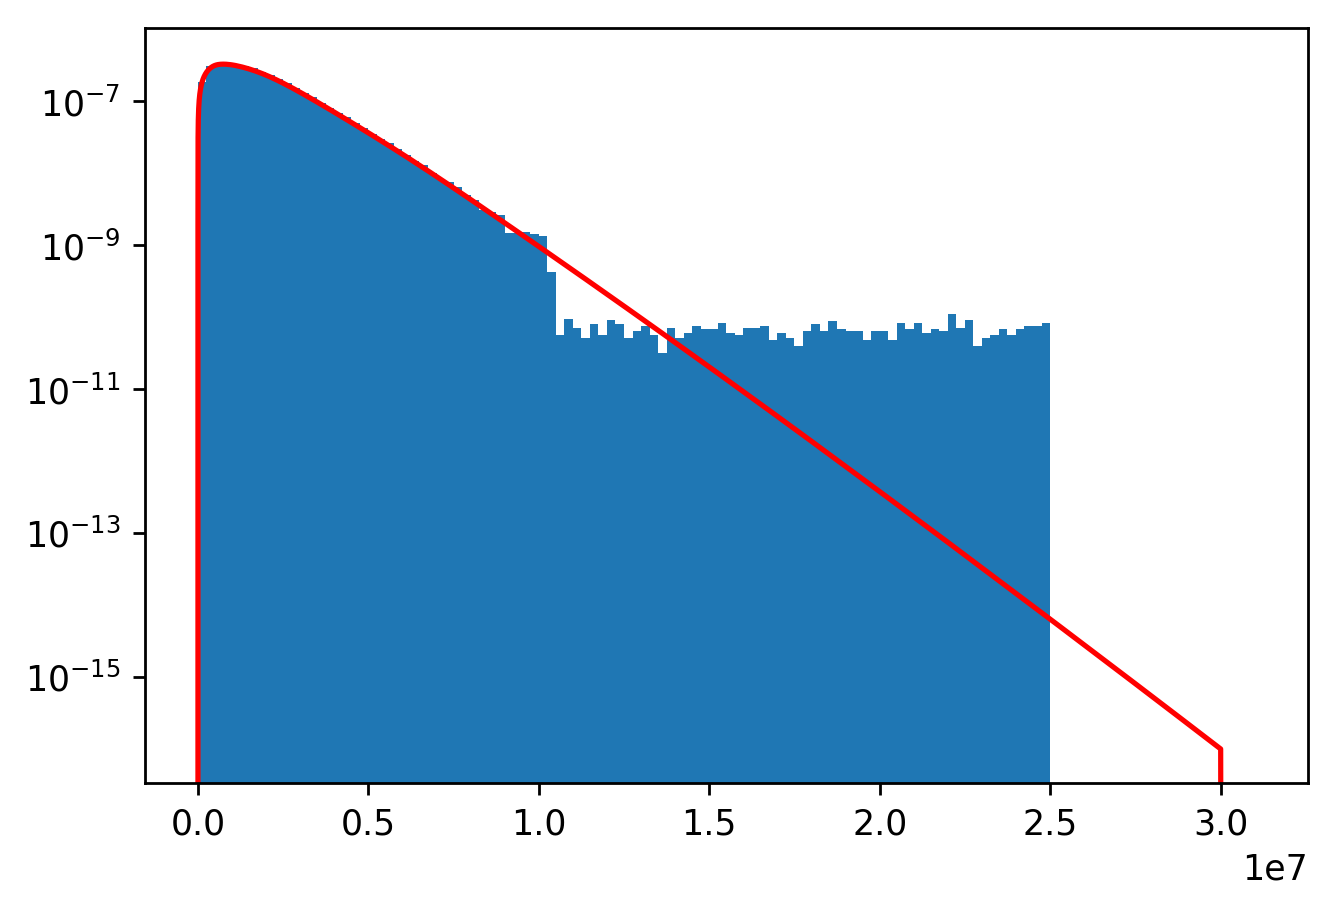

In [22]:
from scipy.integrate import odeint
en=np.linspace(1,2.5e7,1000)

def integrand(y, x):
    ret=fissionE(x)
    return ret

fissionE=interpolate.interp1d(fissionEnergy[:,0].reshape(-1),fissionEnergy[:,1].reshape(-1),kind='cubic')
y=0
dd=odeint(integrand,y,en,rtol=1e-6,atol=0.1)  # default tolerance never converges.
dd=dd/dd[-1]  #normalize to 1

#now we need to get rid of many duplicate bins
xlist=[]
ylist=[]
j=1
i=0
while i+j <len(dd):
    if dd[i+j]/dd[i] >1.002:
        xlist.append(en[i])
        ylist.append(dd[i])
        i=i+j
    else:
        j=j+1
xlist.append(en[i])
ylist.append(dd[i])
xlist.append(en[-1])
ylist.append(dd[-1])
xl=np.array(xlist)
yl=np.array(ylist).reshape(-1)
throwFissionE=interpolate.interp1d(yl,xl) #note that it is easy to invert an table of values by interchanging y,x

plt.figure()
plt.plot(dd,en)
pltx=np.linspace(0,1,1000)
plt.plot(pltx[900:],throwFissionE(pltx[900:]),'r')

plt.figure()
plt.plot(dd[-800:],en[-800:])
pltx=np.linspace(0,1,1000)
plt.plot(pltx[900:],throwFissionE(pltx[900:]),'r')


#plt.plot(en,integrand(0,en))
#plt.yscale('log')

dist=throwFissionE(np.random.rand(1000000))
plt.figure()
plt.plot(fissionEnergy[:,0],4.5e-5*fissionEnergy[:,1],'r')
plt.hist(dist,100,normed=True)
plt.yscale('log')
j=1


What is happening at the very high energies, where statistics are low?  This is a result of the precision of the integration/tabulation. But we will get 99% of the neutrons right, and so we are going to ignore the high energy discrepancy.  If we needed absolute precision at this point I would break the distribution up into two pieces- one  neutrons below 10 MeV and one above. But this doesn't show any new techniques or thinking, so we ill ignore it. 

### Throwing the number of neutrons from fission

Generating the number of neutrons is a little different- because the parameter, "the mean number of neutrons" is then used in a poisson distribution to actually throw an integer number.   We have the mean number of neutrons (from above) contained in the interpolation fissionNumber.  

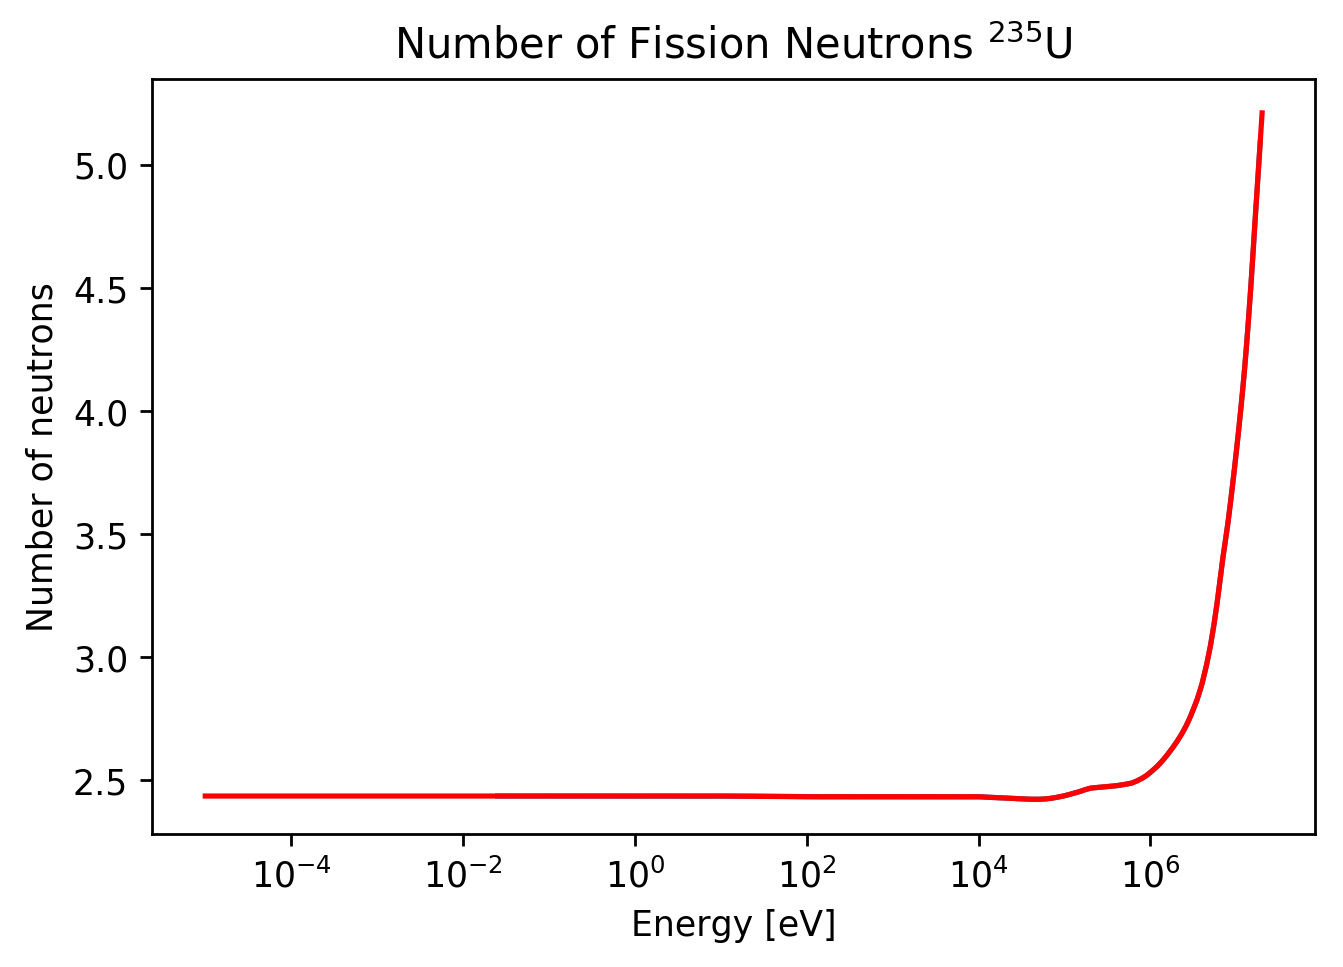

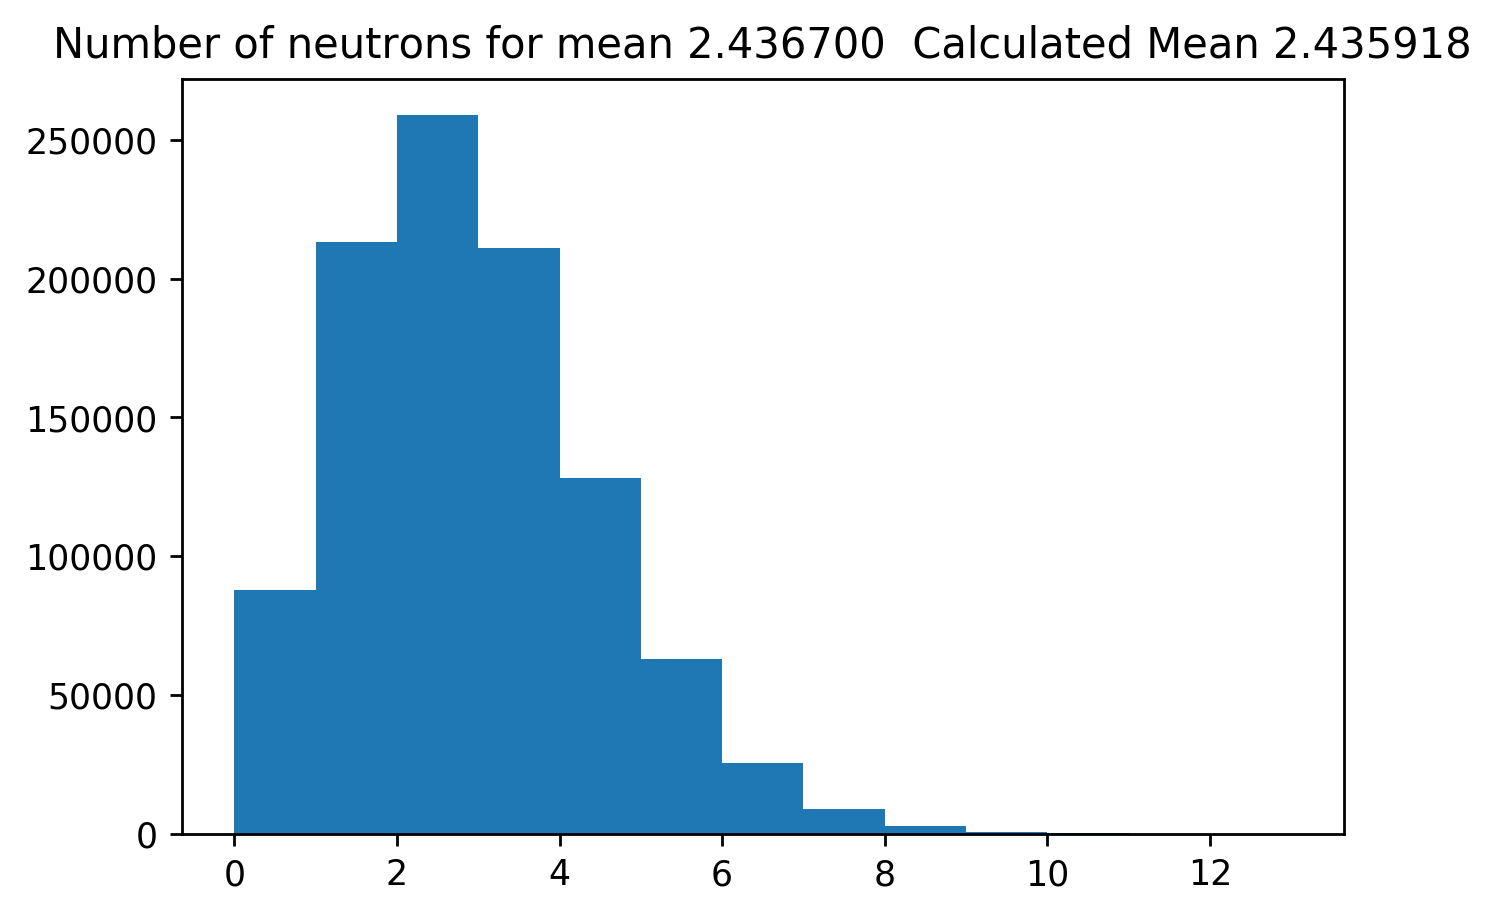

In [24]:

er5=np.logspace(np.log10(fissionN[1,0]),np.log10(1.9e7),2000)
    
plt.figure()
plt.plot(er5,fissionNumber(er5))
plt.plot(fissionN[:,0],fissionN[:,1],'r')
plt.xscale('log')
plt.title(r'Number of Fission Neutrons $^{235}$U')
plt.ylabel('Number of neutrons')
plt.xlabel('Energy [eV]')
bins=np.arange(0,14)

plt.figure()
mean=fissionNumber(1)
ndist=np.random.poisson(mean,1000000)

calcMean=np.mean(ndist)
plt.hist(ndist,bins)  #  note that if we don't do this, the bins are real numbers- and integers get distributed in a funny way
plt.title('Number of neutrons for mean %f  Calculated Mean %f'%(mean,calcMean))


### Rotating a vector
There are multiple ways to rotate a vector in 3d- we could set up matrices that describe rotations about euler angles, for instance.  What we are going to need is to start with a vector and rotate it by a scattering angle $\theta$ around an axis which is chosen randomly (ie.  there is no preferred direction for the orientation of the scattering plane).

We will do this using the Euler-Rodrigues formula: https://en.wikipedia.org/wiki/Euler%E2%80%93Rodrigues_formula .

We do this by finding an arbitrary axis- we will take the cross product between vertical and the direction of motion unless that is zero, in which case we will use horizontal and the direction of motion.  We then rotate by an angle $\theta$ about that axis, and then rotate this by a random angle about the direction of motion.

In [49]:

def rotate(v,omega):
    '''Rotate the vector v around a random direction by an angle omega'''
    k=np.array([0,0,1])
    i=np.array([1,0,0])
    a1=np.cos(omega/2)
    st=np.sin(omega/2)
    axis=np.cross(k,v)
    if np.linalg.norm(axis)==0:
        axis=np.cross(i,v)
    axis=axis/np.linalg.norm(axis)  #unit vector
    b1,c1,d1=st*axis
    
    phi=np.pi*np.random.rand(1) #note that we left out the 2, since a is cos(phi/2)
    a2=np.cos(phi)
    st2=np.sin(phi)
    axis=v/np.linalg.norm(v)
    b2,c2,d2=st2*axis
    
    a=a1*a2-b1*b2-c1*c2-d1*d2
    b=a1*b2+b1*a2-c1*d2+d1*c2
    c=a1*c2+c1*a2-d1*b2+b1*d2
    d=a1*d2+d1*a2-b1*c2+c1*b2
    
    rotation=np.array([[a*a+b*b-c*c-d*d, 2*(b*c-a*d),2*(b*d+a*c)],
                      [2*(b*c+a*d),a*a+c*c-b*b-d*d,2*(c*d-a*b)],
                      [2*(b*d-a*c),2*(c*d+a*b),a*a+d*d-b*b-c*c]]).reshape(3,3)
    return np.dot(rotation,v)

    

Now we validate, by generating random directions with a given rotation angle, and checking that the outgoing vectors are rotated by the same amount.  To check phi rotations we will start with v along the x, y, and z axes, and see that we end up with a uniform distribution.



-0.904072142017
-0.904072142017
-0.904072142017
-0.904072142017
-0.904072142017
-0.904072142017
-0.904072142017
-0.904072142017
-0.904072142017
-0.904072142017
-0.904072142017


(array([ 10109.,  10092.,   9952.,   9965.,  10001.,   9828.,  10081.,
         10062.,  10055.,   9855.]),
 array([ -3.14153173e+00,  -2.51322607e+00,  -1.88492040e+00,
         -1.25661474e+00,  -6.28309069e-01,  -3.40358731e-06,
          6.28302262e-01,   1.25660793e+00,   1.88491359e+00,
          2.51321926e+00,   3.14152493e+00]),
 <a list of 10 Patch objects>)

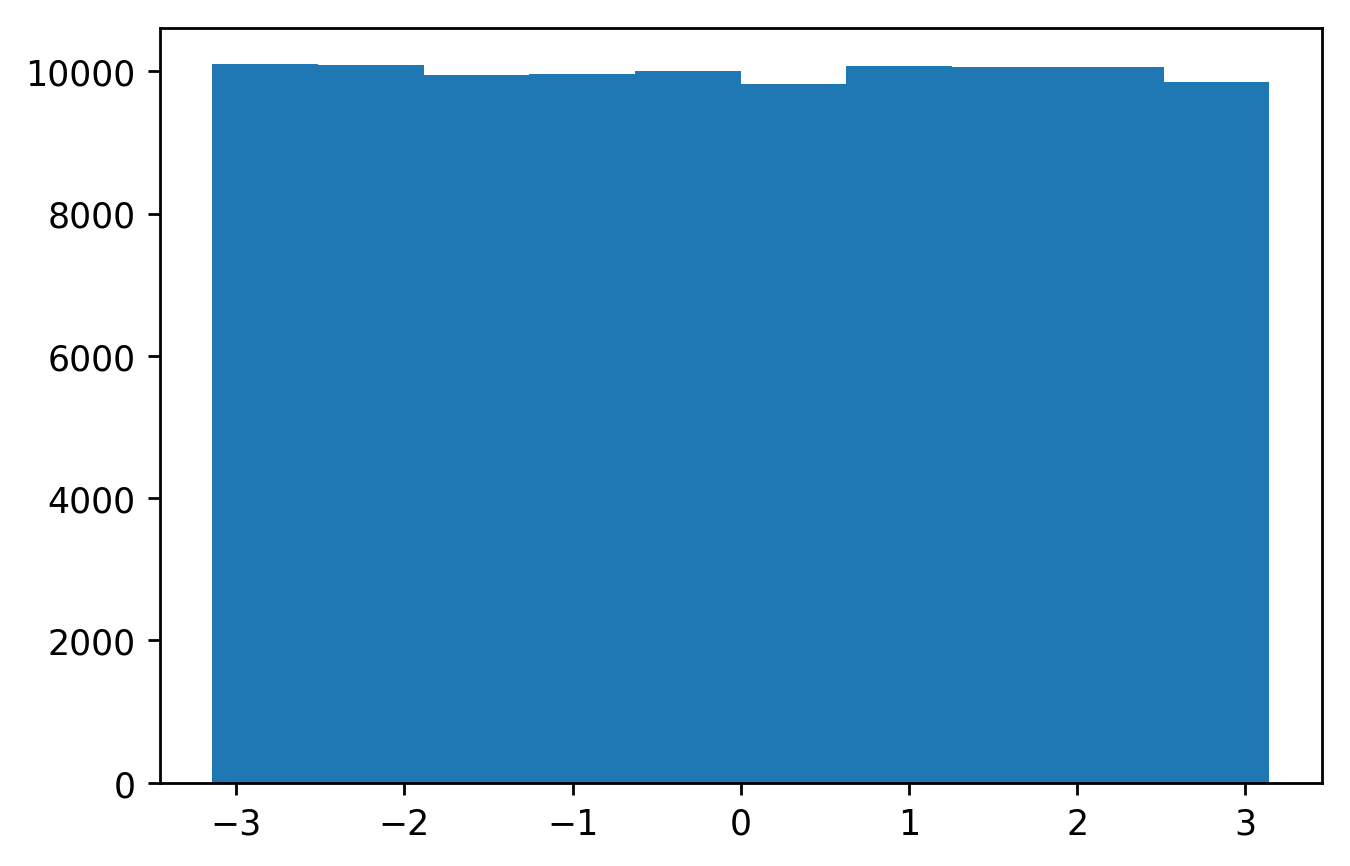

In [50]:
N=10
ct=np.random.rand(N)*2-1
phi=np.random.rand(N)*2*np.pi
st=np.sqrt(1-ct*ct)
cp=np.cos(phi)
sp=np.sin(phi)
x=10*st*cp #pick 10 as the magnitude of the velocity
y=10*st*sp
z=10*ct
v=np.array([x,y,z]).transpose()

angle=2.7  #amount of rotation
for vel in v:
    vout=rotate(vel,angle)
    print(np.dot(vout,vel)/100)
print(np.cos(angle))

vel=np.array([10,0,0 ])
N2=100000
vout=np.empty((N2,3))
for ii in np.arange(0,N2):
    vout[ii]=rotate(vel,angle)

plt.figure()
plt.hist(np.arctan2(vout[:,2],vout[:,1]))


Organizationally, where should we put the scattering class?  It could go into the neutron class or the material class- but since it affects parameters in the neutron more than materials, we will put it into the neutron class.

Now for the material class, which contains all the information about materials and how they interact with neutrons.  This will be the only class that is different for U235, U238, water, etc. etc.

We will need to calculate the energy loss in an elastic collision.  This is actually the most complicated interaction, since we need to calculate kinematics rather than just throw distributions.  




### The Material class
Now we pull all the cross sections together into the "materials" class.  For different materials,  such U238 or H2O - will still be "materials" but will have different cross section tables.  

The Material class will need to calculate the energy and direction for elastic scattering.  It does this inside the 
U235ElasticCosTheta(self,energy) method.

Here we apply the equations, with subscripts n, t and cm referring to the neutron, the target and the center of mass, respectively.  We use primes for quantities referenced to the CM and unprimed quantities in the lab frame.
\begin{equation}\vec{v_{cm}}=\frac{m_n}{m_n+m_t}\vec{v_n}\end{equation}
\begin{equation}\vec{v_n'}=\frac{m_t}{m_n+m_t}\vec{v}\end{equation}
\begin{equation}\vec{v_t'}=-\frac{m_n}{m_n+m_t}\vec{v}\end{equation}
We pick the incident direction as the x-axis, and do the scattering, which has a cm angle $\cos\theta$, but doesn't change the magnitude of the cm velocities: 
\begin{equation}\vec{v_{fn}'}=\frac{m_t}{m_n+m_t}v_n(\cos\theta',\sin\theta',0)\end{equation}
\begin{equation}\vec{v_{ft}'}=-\frac{m_n}{m_n+m_t}v_n(\cos\theta',\sin\theta',0)\end{equation}
and then express the neutron velocity in the lab:
\begin{equation}\vec{v_{fn}}=\frac{1}{m_n+m_t}v_n(m_t\cos\theta'+m_n,m_t\sin\theta',0)\end{equation}
\begin{equation}E=\frac{1}{2}m_nv_{fn}^2=\frac{1}{2}m_nv_{n}^2\frac{1}{(m_n+m_t)^2}(m_n^2+m_t^2+2m_nm_t\cos\theta')\end{equation}
\begin{equation}\cos\theta=\frac{\vec{v_{fn}}\cdot\vec{v_n}}{|\vec{v_{fn}}\cdot\vec{v_n}|}=\frac{m_t\cos\theta'+m_n}{\sqrt{m_n^2+m_t^2+2m_nm_t\cos\theta'}}\end{equation}
\begin{equation}\end{equation}


In [26]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure',dpi=250)
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from fissionMC import Neutron

class Material:
    '''Material contains the information about cross sections, densities, etc.  It is able to return the distance to 
    the next physics interaction and the type of interactions, and energies of elastic scattered and fission neutrons
    
    To use the class one uses three commands
    variable=Material('U235)
    fractions(energy)   to get the interaction length and the fractions of various types of scatters
    interaction(energy) to get the parameters of the interaction
    
    '''
    
        
    def fractions(self,energy):
        '''Returns the interaction length corresponding to the total cross section,
        the elastic fraction, and the elastic+fission fraction'''
        total=self.totalXS(energy)
        elastic=self.elasticXS(energy)
        fission=self.fissionXS(energy)
        interactionLength=1.0/(self.interactionLambda*self.totalXS(energy))
        return(interactionLength,elastic/total,(elastic+fission)/total)
        
    def interaction(self,energy):
        '''Calculates the probability of elastic scattering or fission.  
        Energy is the energy of the neutron in this material.
        For elastic scattering returns True, interactionLength,(cosTheta, Center of Mass velocity/velocity ).  
        Here cos theta is the cosine of the scattering angle.
        For fission returns False, interactionLength,(energy of daughters)'''
        interactionLength,elasticFraction,fissionFraction=self.fractions(energy)
        rn=np.random.rand()
        #go through the different scattering mechanisms
        if rn<elasticFraction:
            elastic=True
            retval=self.elasticCosTheta(energy)
            self.cthetaHist.append([energy,np.asscalar(retval[-1])])
        elif rn<fissionFraction:  #fissions
            elastic=False
            nDaughters=np.random.poisson(self.fissionNumber(energy))
            self.nDaughtersHist.append([energy,nDaughters])
            retval=[]
            for ix in np.arange(0,nDaughters):
                #throwFissionE returns an array
                retval.append(np.asscalar(self.throwFissionE(np.random.rand())))
                self.daughterHist.append(retval[-1])
            if nDaughters==0:  #fission without daughters
                retval.append(0)  # allows us to distinguish 0 fission captures from escapes
        else:  #treat inelastic scatters like elastic scatters, except don't histogram
            elastic=True
            retval=self.elasticCosTheta(energy)
        self.distanceHist.append([energy,interactionLength])    
        return (elastic,interactionLength,retval)    
    
    def U235Initialize(self):
        #start by reading in the angular distribution legendre polynomials
        self.energyList=[]
        self.throwAngles=[]
        self.legendreList=[]
        k=0
        lfactor=np.arange(0,30)+0.5 #(2L+1)/2 normalization of legendre polynomials
        with open('angularDistU235Elastic.txt', 'r') as f:
            for line in f:
                if 'Angular' in line:
                    pass
                elif 'eV  Coefficients' in line:
                    pass
                elif '-----' in line:
                    pass
                elif len(line)==1:
                    pass
                else:
                    if not line[0:10].isspace():
                        energy=float(line[0:10]+'e'+line[10:12])
                        self.energyList.append(energy)
                        if len(self.energyList)>1:
                            leg=np.polynomial.legendre.Legendre(np.array(l)*lfactor[:len(l)])
                            self.legendreList.append(leg)
                            leg0=leg.integ()  # integral from zero
                            legendreIntegral=leg0-leg0(-1) #integral from -1
                            xv=legendreIntegral.linspace(200)
                            intLeg=interp1d(xv[1],xv[0],kind='cubic')
                            self.throwAngles.append(intLeg)
                            k=k+1
                        l=[1.0]
                    for i in range(13,79,11):
                        if not(line[i:i+9].isspace()):
                            coeff=float(line[i:i+9]+'e'+line[i+9:i+11])
                            l.append(coeff)
        #append the last values for throwAngles and legendreList
        leg=np.polynomial.legendre.Legendre(np.array(l)*lfactor[:len(l)])
        self.legendreList.append(leg)
        leg0=leg.integ()  # integral from zero
        legendreIntegral=leg0-leg0(-1) #integral from -1
        xv=legendreIntegral.linspace(200)
        intLeg=interp1d(xv[1],xv[0],kind='cubic')
        self.throwAngles.append(intLeg)
                            
        #now read in the elastic cross section
        elasticXdata=np.genfromtxt('ElasticCrossSectionU235.txt',skip_header=1,delimiter=',')
        #the following two lines elements where two subsequent entries have the same x value.  Spline can't interpolate those!
        dd=np.where(elasticXdata[1:,0]<=elasticXdata[:-1,0])[0]
        elasticXdata=np.delete(elasticXdata,dd,axis=0)
        self.elasticXS=interp1d(elasticXdata[:,0].reshape(-1),elasticXdata[:,1].reshape(-1),
                                bounds_error=False,fill_value=0.0)
         
        #total cross section
        totalXdata=np.genfromtxt('TotalCrossSectionU235.txt',delimiter=',',skip_header=1)
        self.totalXS=interp1d(totalXdata[:,0].reshape(-1),totalXdata[:,1].reshape(-1),kind='cubic',
                              bounds_error=False, fill_value=0.001)

        #fission cross section
        fissionXdata=np.genfromtxt('FissionCrossSectionU235.txt',skip_header=1,delimiter=',')
        #the following two lines elements where two subsequent entries have the same x value.  Spline can't interpolate those!
        dd=np.where(fissionXdata[1:,0]<=fissionXdata[:-1,0])[0]
        fissionXdata=np.delete(fissionXdata,dd,axis=0)
        self.fissionXS=interp1d(fissionXdata[:,0].reshape(-1),fissionXdata[:,1].reshape(-1),bounds_error=False,
                                fill_value=0.0)

        #fission Energy
        fissionEnergy=np.genfromtxt('FissionOutgoingEnergySpectraU235.txt',skip_header=5)
        self.fissionE=interp1d(fissionEnergy[:,0].reshape(-1),fissionEnergy[:,1].reshape(-1))

        #now number of fission daughters
        fissionN=np.genfromtxt('NumberNeutronsU235.txt',skip_header=1,delimiter=',')
        self.fissionNumber=interp1d(fissionN[:,0].reshape(-1),fissionN[:,1].reshape(-1))
                                                                      

        #interpolation function to thow the fission energy                                                                   `
        integrand = lambda y, x:self.fissionE(x)
        y=0
        en=np.linspace(1,2.5e7,1000)
        dd=odeint(integrand,y,en,rtol=1e-6,atol=0.1)  # default tolerance never converges.
        dd=dd/dd[-1]  #normalize to 1

        #now we need to get rid of many duplicate bins
        xlist=[]
        ylist=[]
        j=1
        i=0
#        import pdb; pdb.set_trace()
        while i+j <len(dd):
            if i==0 or dd[i+j]/dd[i] >1.002:
                xlist.append(en[i])
                ylist.append(dd[i])
                i=i+j
            else:
                j=j+1
            xlist.append(en[i])
            ylist.append(dd[i])
        xlist.append(en[-1])
        ylist.append(dd[-1])
        xl=np.array(xlist)
        yl=np.array(ylist).reshape(-1) 
        self.throwFissionE=interp1d(yl,xl) #note that it is easy to invert an table of values by interchanging y,x
        
    def U235ElasticCosTheta(self,energy):
        k=np.searchsorted(self.energyList,energy)  #find  bin number
        if k<0 or k>=len(self.energyList):
#            print('energy overflow',energy,k,len(self.energyList),len(self.throwAngles))
            self.overFlowCounter+=1
            k=len(self.energyList)-1
        if k+1<len(self.energyList) and self.energyList[k+1]-energy<energy-self.energyList[k]:  
            k=k+1
        ctheta=self.throwAngles[k](np.random.rand())
        stheta=np.sqrt(1-ctheta**2)
        vt=Neutron.mass**2+self.mass**2+2*Neutron.mass*self.mass*ctheta
        eFinal=energy*vt/(Neutron.mass+self.mass)**2
        ct=(self.mass*ctheta+Neutron.mass)/np.sqrt(vt)
#        ct=np.cos(np.arctan(self.mass*stheta/(Neutron.mass+self.mass*ctheta)))
        return(eFinal,ct)


    def __init__(self, name):
        '''Initialization for each isotope.  At a minimum need to define self.mass, 
        the elastic scattering cross section and angle, self.elasticXS(E) and self.elasticCosTheta
        the fission cross section and number of neutrons, self.fissionXS(E)
        the fission energy distribution self.fissionE(E), self.fissionE(E)'''
        if 'U235' in name:
            print('Starting to initialize U235')
            self.mass=235.04*931.5e6  #mass mc**2 in eV
            self.density=19.1*235/238
            self.interactionLambda=1e-24*6.02e23/235.04*self.density #cm**2 *NA/mass per mole *gm/cm**3=1/cm
            self.U235Initialize()
            self.elasticCosTheta=self.U235ElasticCosTheta
            self.overFlowCounter=0
        

#initialize lists of variables to be histogrammed
        self.cthetaHist=[]
        self.nDaughtersHist=[]
        self.daughterHist=[]
        self.distanceHist=[]
        
  
    def validate(self):
        capture=[]
        erange=np.linspace(1,1e6,1000)
        for e in erange:
            capture.append(self.fractions(e))
        capture=np.array(capture).transpose()
        plt.figure()
        plt.plot(erange,1.0/capture[0],'r',label='fraction calculation')
        plt.plot(erange,self.totalXS(erange), label='Interpolation')
        plt.plot(erange,self.totalXS(erange)*capture[0],'g',label='ratio calculation')
        plt.legend()
        plt.title('Total Cross sections')
        plt.xlabel('Energy of neutron(eV)')
        plt.ylabel('Cross Section, Barns')        
        plt.yscale('log')
        plt.figure()
        plt.hist(self.totalXS(erange)*capture[0],bins=100,range=(20.440,20.442))
        
        plt.figure()
        plt.plot(erange,capture[1]/capture[0],'r',label='fraction calculation')
        plt.plot(erange,self.elasticXS(erange), label='Interpolation')
        plt.plot(erange,self.elasticXS(erange)*capture[0]/capture[1],'g',label='ratio calculation')
        plt.legend()
        plt.title('Elastic Cross sections')
        plt.xlabel('Energy of neutron(eV)')
        plt.ylabel('Cross Section, Barns')        
        plt.yscale('log')

        plt.figure()  #for fission we need to subtract because the fraction includes elastic
        plt.plot(erange,(capture[2]-capture[1])/capture[0],'r',label='fission calculation')
        plt.plot(erange,self.fissionXS(erange), label='Interpolation')
        plt.plot(erange,self.fissionXS(erange)*capture[0]/(capture[2]-capture[1]),'g',label='ratio calculation')
        plt.legend()
        plt.title('Fission Cross sections')
        plt.xlabel('Energy of neutron(eV)')
        plt.ylabel('Cross Section, Barns')        
        plt.yscale('log')
        
        #For interaction we will look at the number of fissions compared to the number of elastic scatters, 
        #the energy distribution of the fissions, and the angular distribution of the scatters.
    
        erange2=np.linspace(1,1e6,10)
        for e in erange2:
            for i in range(0,10000):
                elastic, length, data=self.interaction(e)
 





In [27]:
u235=Material('U235')
help(Material)

Starting to initialize U235
Help on class Material in module __main__:

class Material(builtins.object)
 |  Material contains the information about cross sections, densities, etc.  It is able to return the distance to 
 |  the next physics interaction and the type of interactions, and energies of elastic scattered and fission neutrons
 |  
 |  To use the class one uses three commands
 |  variable=Material('U235)
 |  fractions(energy)   to get the interaction length and the fractions of various types of scatters
 |  interaction(energy) to get the parameters of the interaction
 |  
 |  Methods defined here:
 |  
 |  U235ElasticCosTheta(self, energy)
 |  
 |  U235Initialize(self)
 |  
 |  __init__(self, name)
 |      Initialization for each isotope.  At a minimum need to define self.mass, 
 |      the elastic scattering cross section and angle, self.elasticXS(E) and self.elasticCosTheta
 |      the fission cross section and number of neutrons, self.fissionXS(E)
 |      the fission energy 

### Validating the materials class

We will write a member function, showHistogram, that goes through and plots the various distributions that have been generated in a run of the monteCarlo.  

We have made histograms of each sample thrown.  To do this we need a list, to which we append values every time we throw new ones.  



Starting to initialize U235


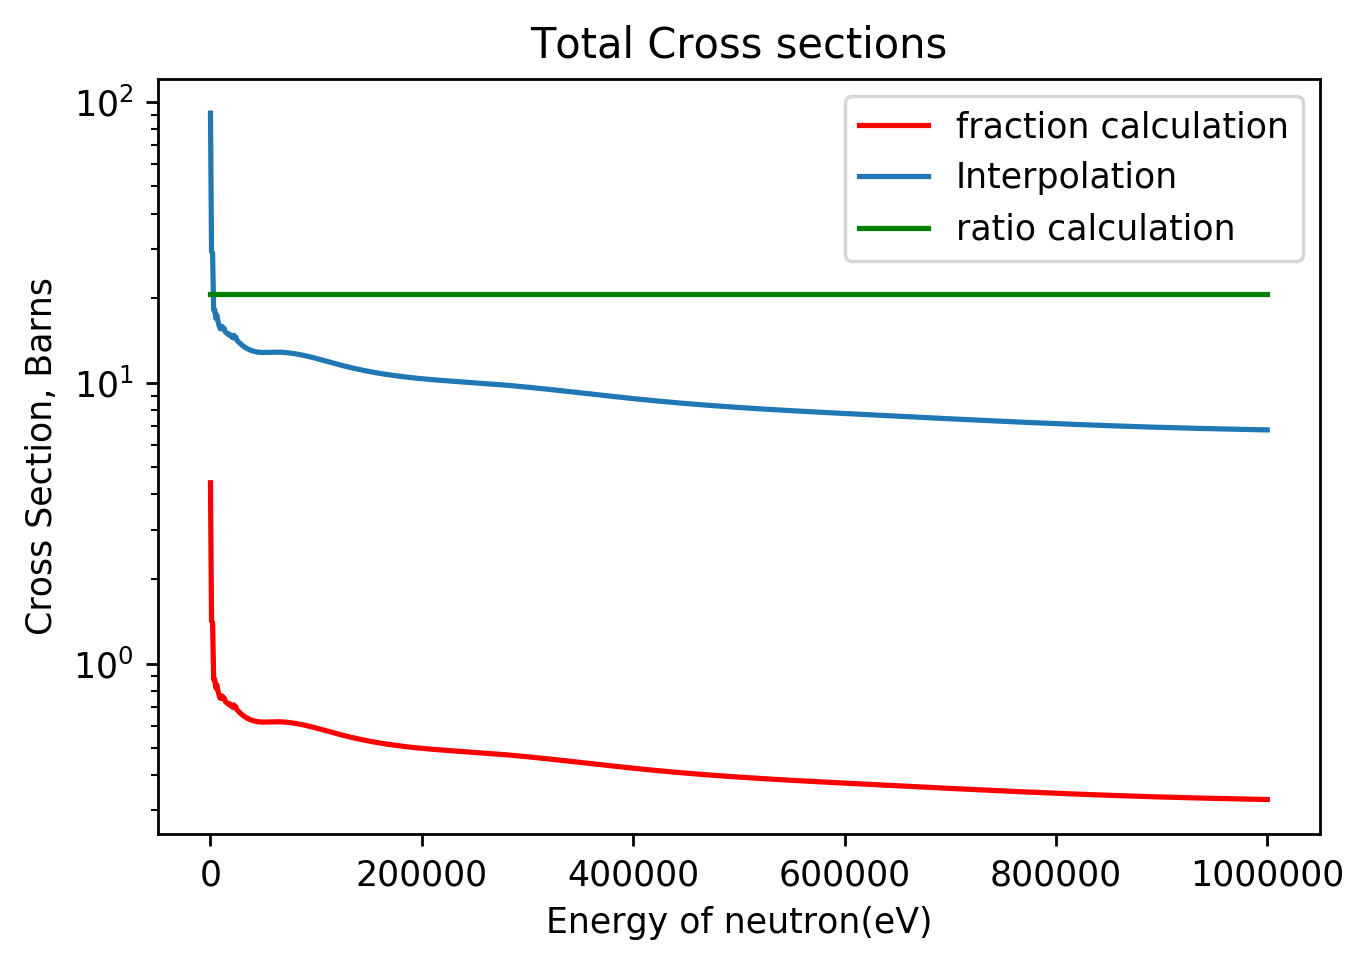

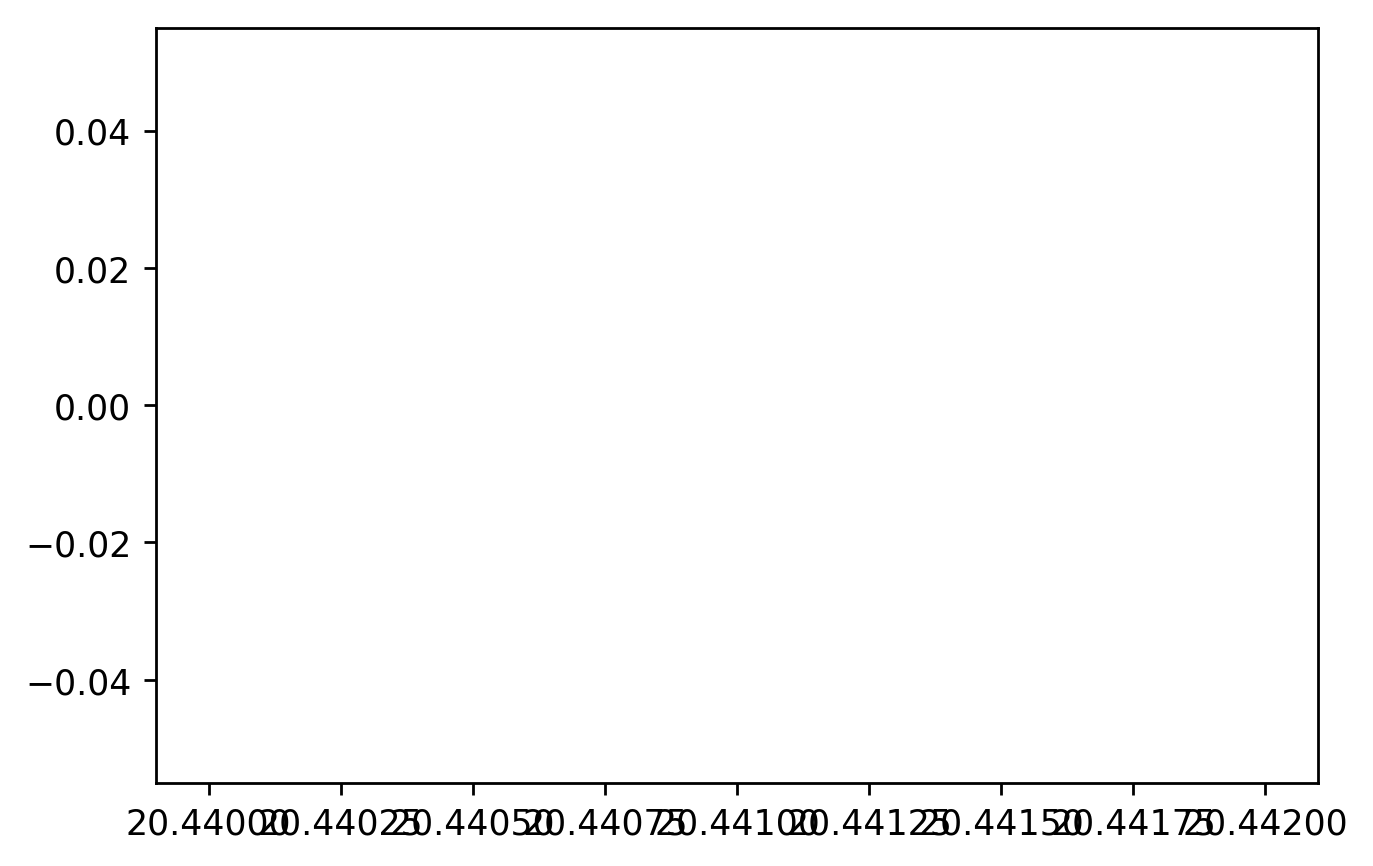

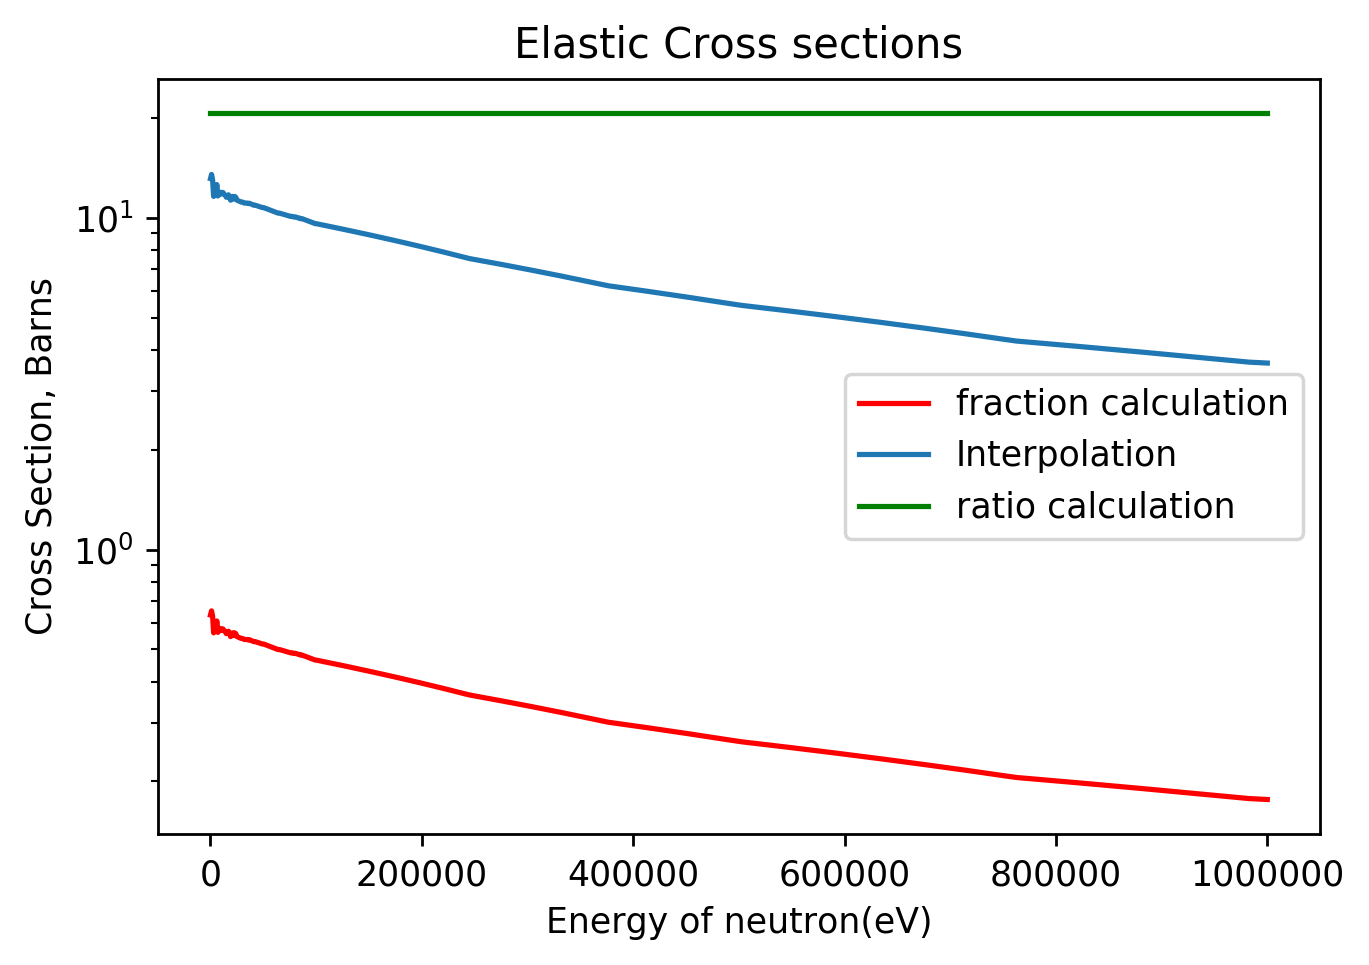

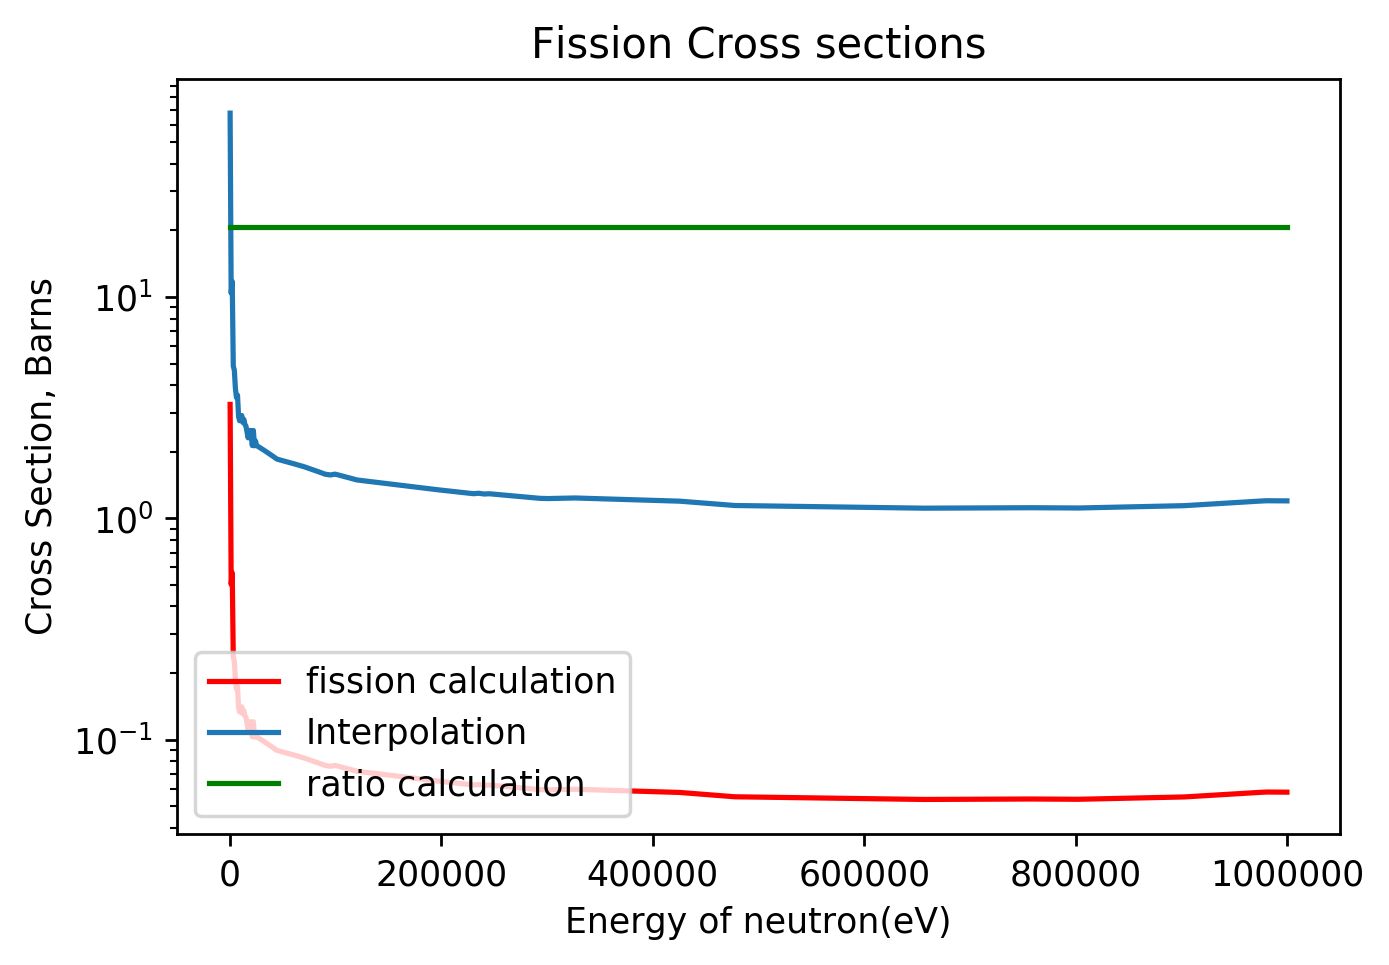

In [28]:
u235=Material('U235')
u235.validate()

Here we make the validation plots.  We could move these into a "histogram method" inside the class; but there is an advantage to being able to tune things interactively.

(2, 20491)


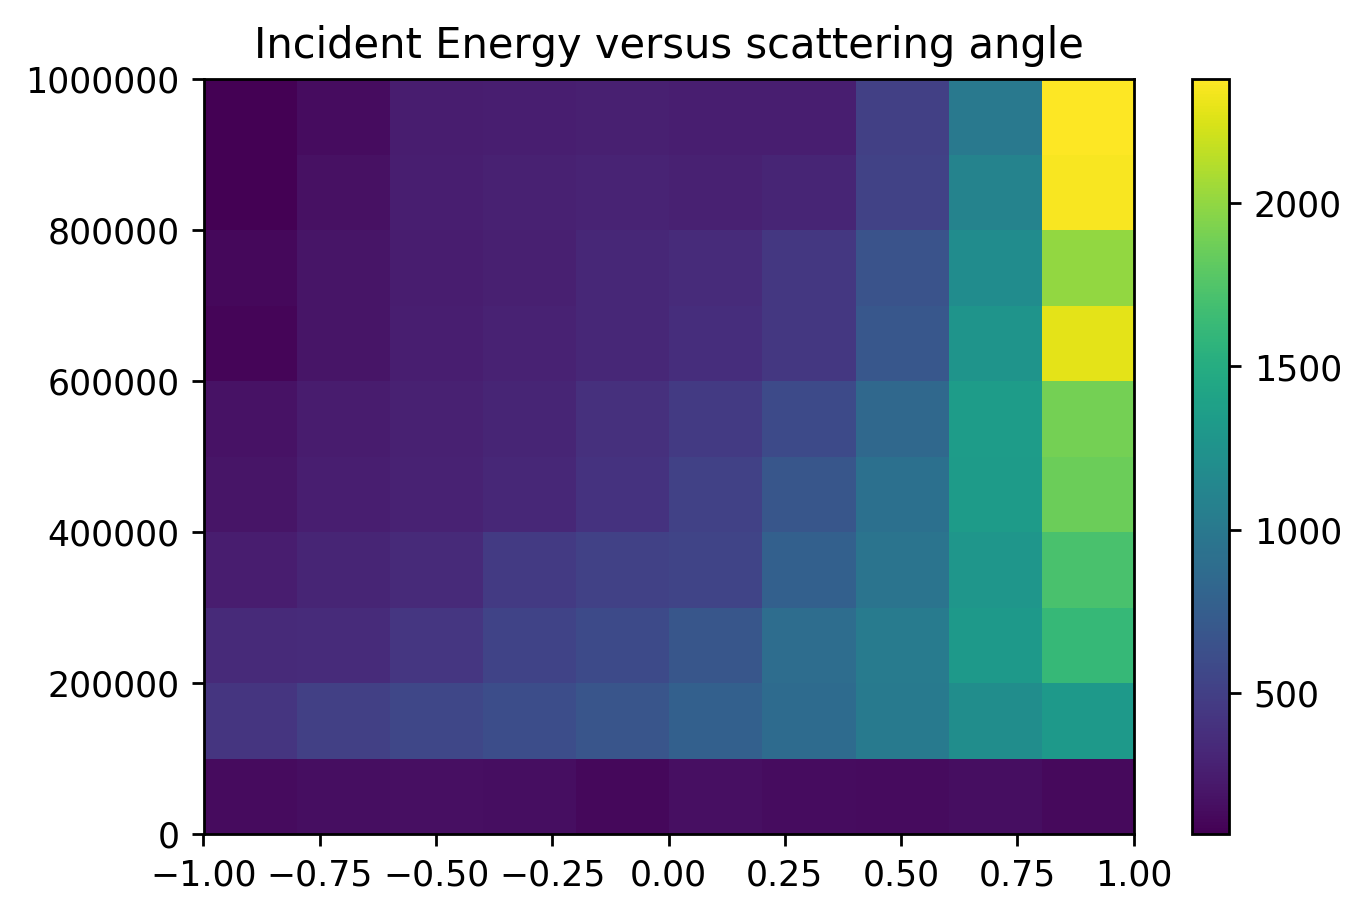

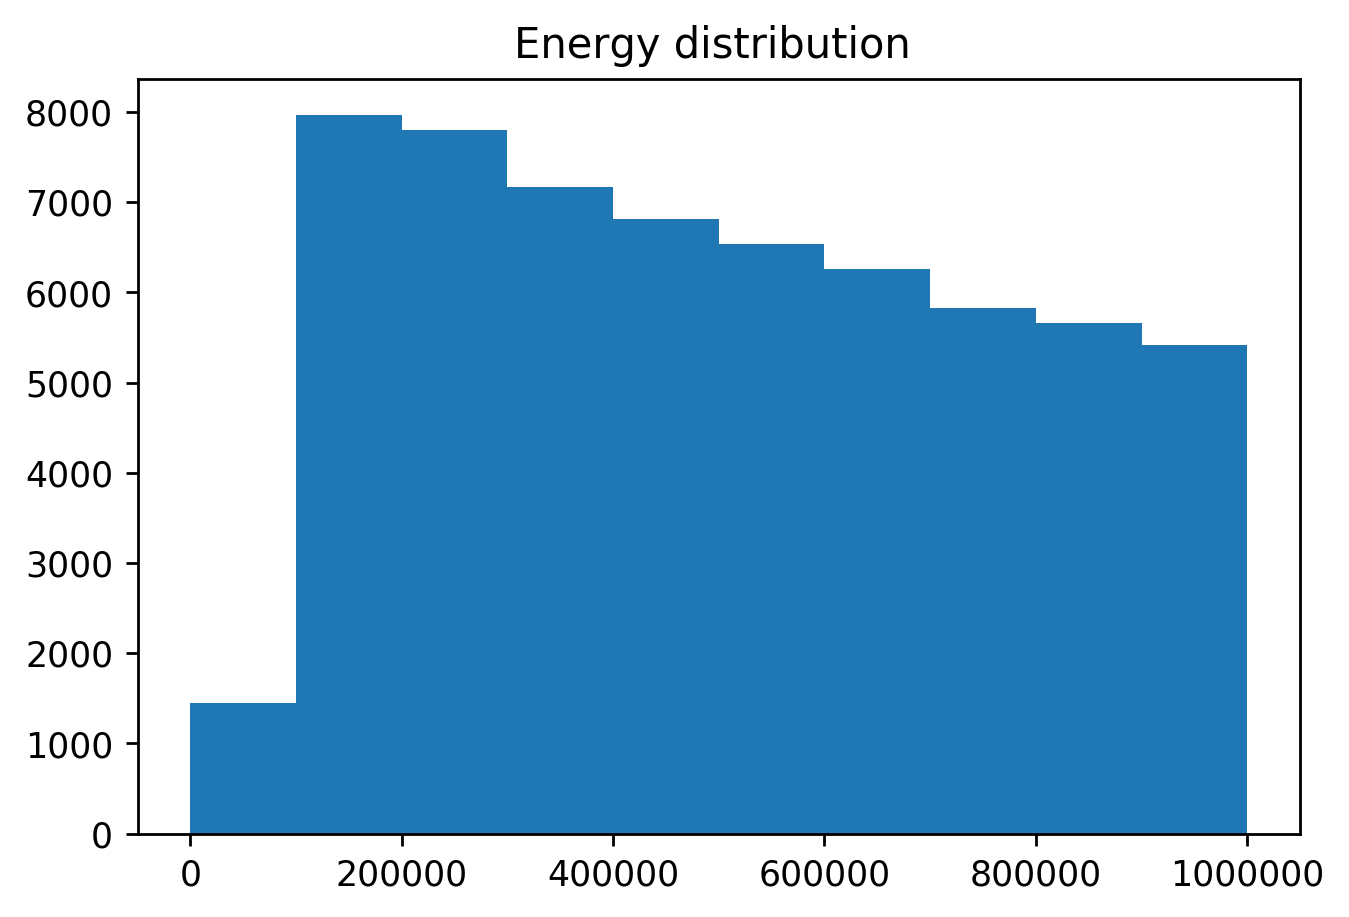

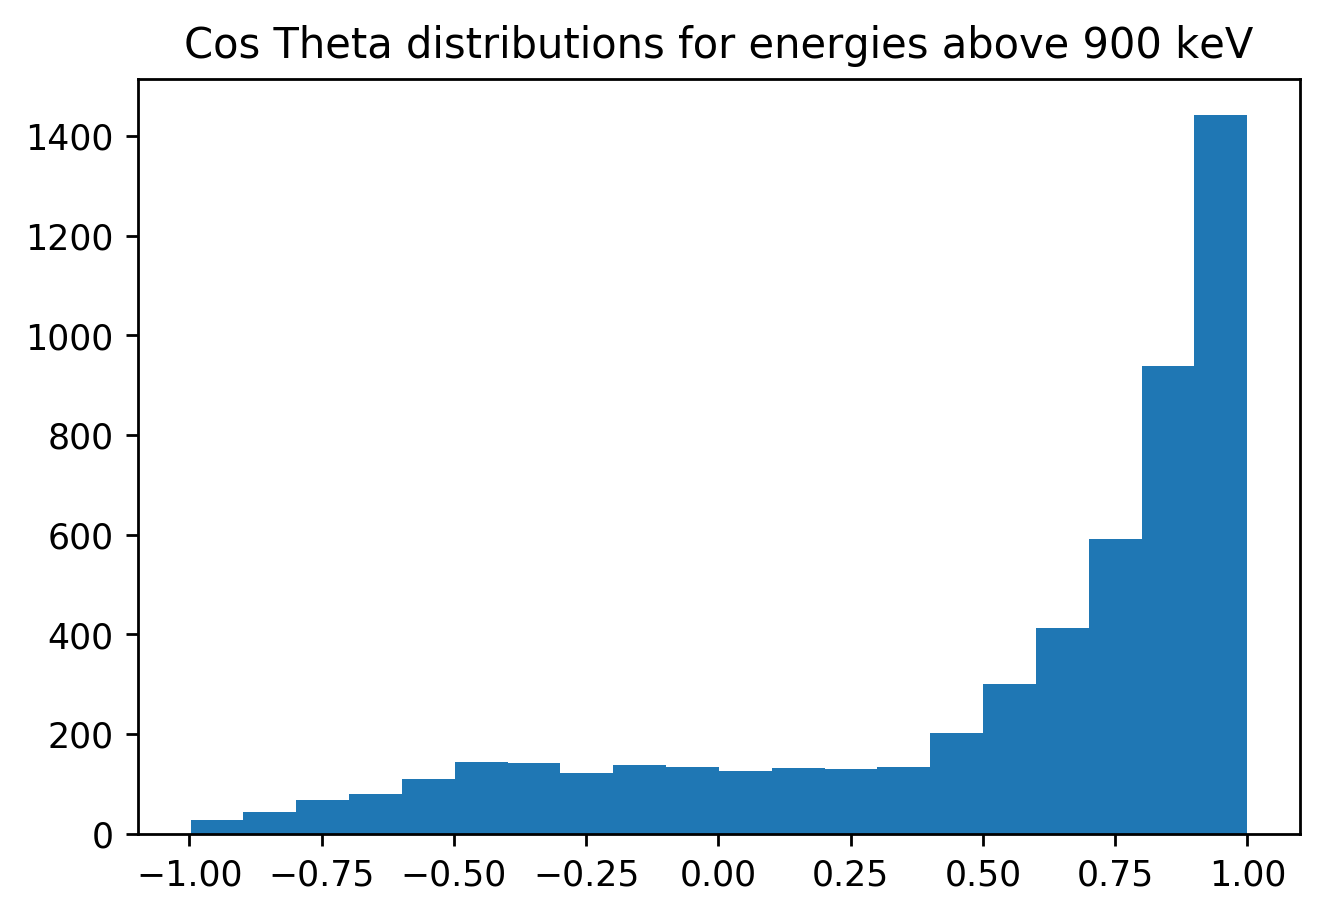

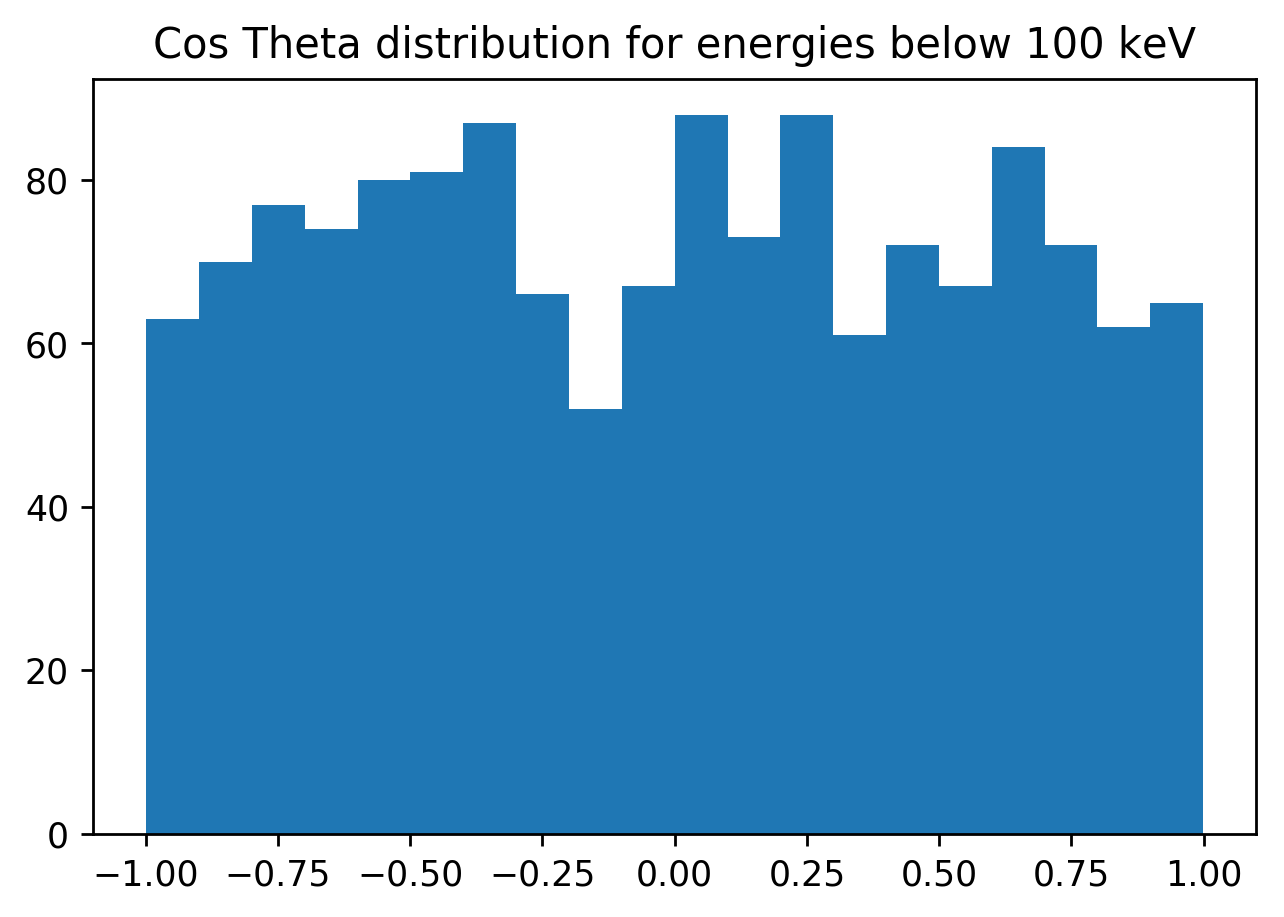

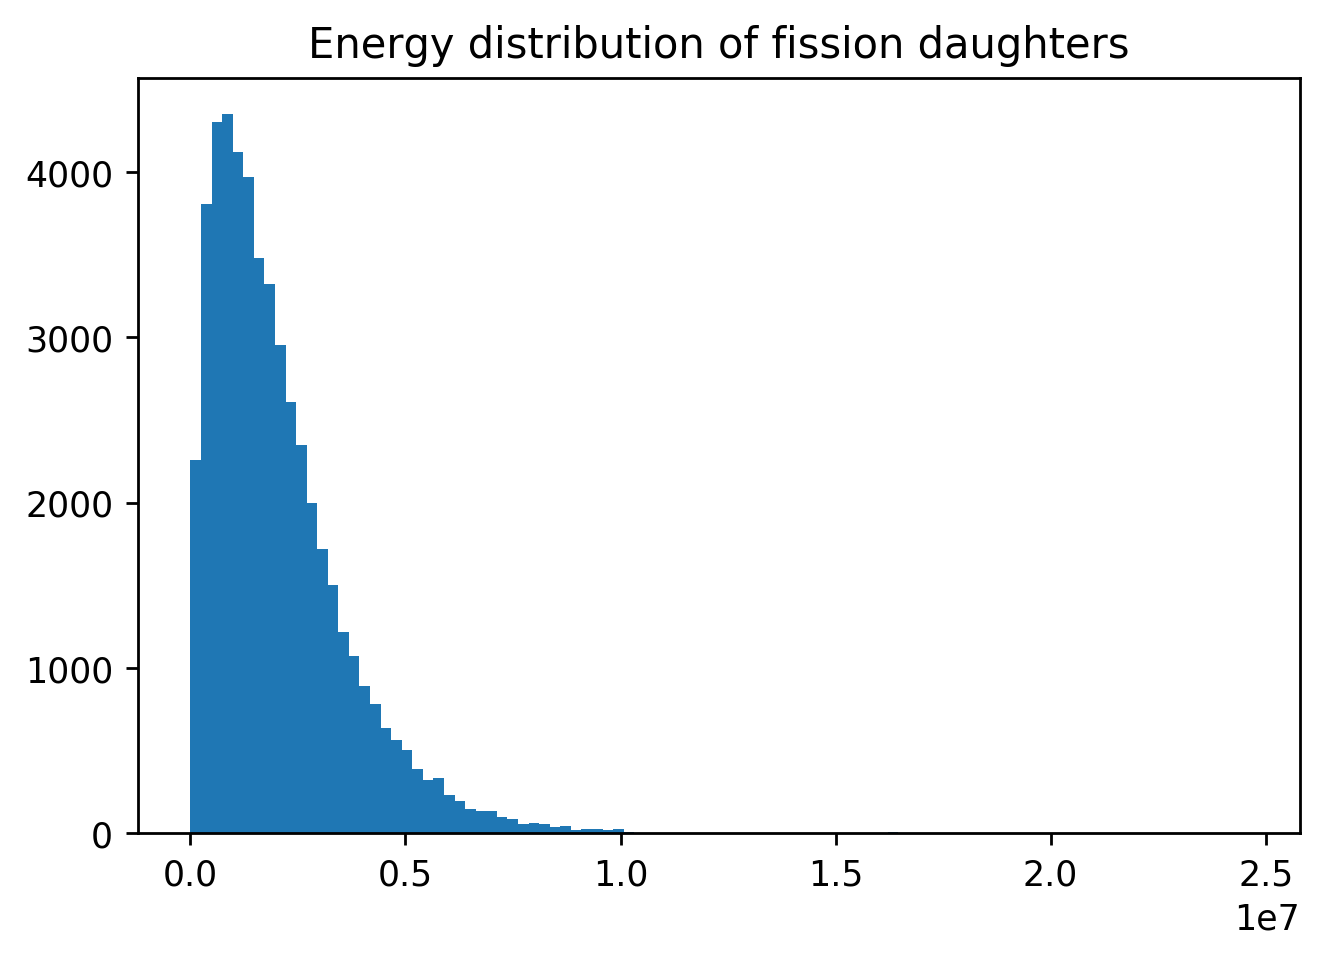

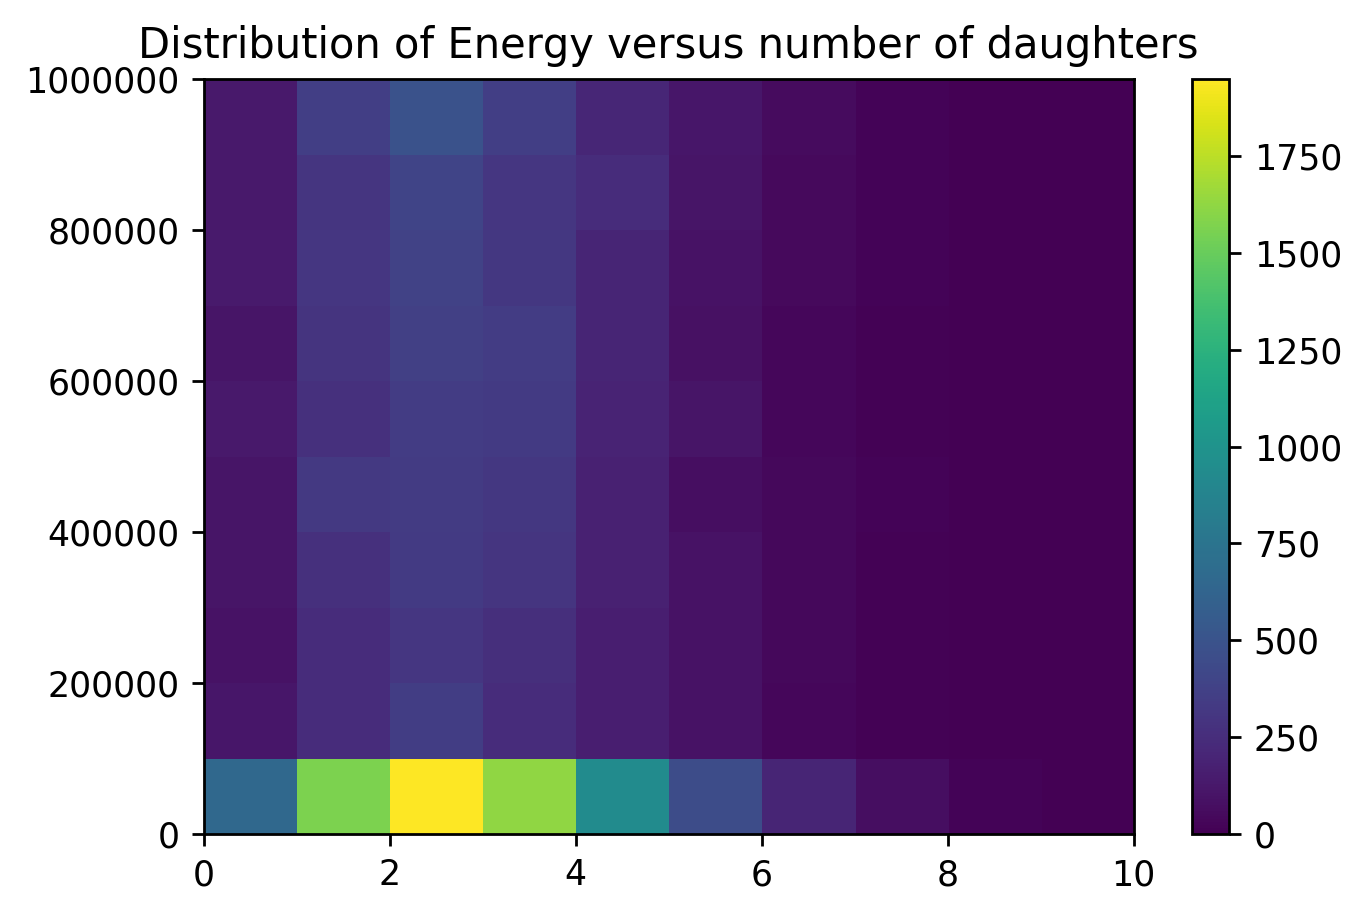

In [29]:
aa=np.array(u235.cthetaHist).transpose()
plt.figure()
plt.title('Incident Energy versus scattering angle')
plt.hist2d(aa[1],aa[0])
plt.colorbar()
plt.figure()
plt.title('Energy distribution ')
plt.hist(aa[0])
plt.figure()
cut=np.where(aa[0]>900000)[0]
plt.title('Cos Theta distributions for energies above 900 keV')
plt.hist(aa[1,cut[0]:cut[-1]],20)
plt.figure()
plt.title(('Cos Theta distribution for energies below 100 keV'))
cut=np.where(aa[0]<100000)[0]
plt.hist(aa[1,cut[0]:cut[-1]],20)

bb=np.array(u235.daughterHist)
plt.figure()
plt.title('Energy distribution of fission daughters')
plt.hist(bb,100)

cc=np.array(u235.nDaughtersHist).transpose()
print (cc.shape)
plt.figure()
plt.title('Distribution of Energy versus number of daughters')
plt.hist2d(cc[1],cc[0])
plt.colorbar()

Now we save Material class into fissionMC.py and then we can "import" it.

We then write the geometry class- which actually throws the positions energies and determines whether or not the neutron interacts before it leaves the material.

We save some computer time by generating 1000 entries at a time.  The critical part of the code is NextInteraction, which determines where the neutron will intersect the object.  This gets compared to the distance to the next "physics interaction" (ie.  elastic scattering or fission)- and the shortest distance gets picked.

In [12]:
from fissionMC import Material

class Geometry:
    '''Geometry defines shapes and uses materials.  We start with a simple sphere of radius r_sphere'''
    
    throwN=1000  #number of items to throw at once
    position=throwN
    direction=throwN
     
    def ThrowPositions(self):  #throws positions within a sphere
        self.position=0
        radii=self.radius*np.random.rand(self.throwN)**(1/3)
        costheta=np.random.rand(self.throwN)*2-1
        sintheta=np.sqrt(1-costheta**2)
        phi=np.random.rand(self.throwN)*2*np.pi
        self.positions=np.array(radii*[sintheta*np.cos(phi),sintheta*np.sin(phi),costheta]).transpose()

    def ThrowDirections(self):  #throws isotropic directions
        self.direction=0
        costheta=np.random.rand(self.throwN)*2-1
        sintheta=np.sqrt(1-costheta**2)
        phi=np.random.rand(self.throwN)*2*np.pi
        self.directions=np.array([sintheta*np.cos(phi),sintheta*np.sin(phi),costheta]).transpose()
        
    def ThrowEnergies(self):  #throws energies according to fission energy distribution
        self.eIndex=0        
        self.energies=self.mat.throwFissionE(np.random.rand(self.throwN))

        
    def GetPosition(self):
        if self.position>=self.throwN:
            self.ThrowPositions()
        retval=self.positions[self.position]
        self.position+=1
        return retval
    
    def GetDirection(self):       
        if self.direction>=self.throwN:
            self.ThrowDirections()
        retval=self.directions[self.direction]
        self.direction=self.direction+1
        return retval

    def GetEnergy(self):
        if self.eIndex>=self.throwN:
            self.ThrowEnergies()
        retval=self.energies[self.eIndex]
        self.eIndex=self.eIndex+1
        return retval
    
    def FirstNeutron(self):
        return (self.GetPosition(),self.GetDirection(),self.GetEnergy())
        
    def NextInteraction(self,neutron):
        '''This routine checks for the next intersection with the sphere, or where the next nuclear interaction 
        will happen
        NextInteraction determines whether the neutron leaves the sphere, fissions, elastically scatters.  
        it returns with the time to the interaction and a tuple that contains information about outgoing neutrons
        for fissions interaction contains the number of daughters
        for geometrical events or when there are zero neutrons generated, interaction is empty'''
        
        #solve for the distance
        d=np.roots(np.array([1,2*np.dot(neutron.position,neutron.direction),np.dot(neutron.position,neutron.position)-self.radius**2]))
        dpos=1e10  #distance to next interaction
        for dd in d: #check if the interaction is a geometrical border crossing  
            if dd>0 and dd<dpos:
                dpos=dd
        if dpos==1e10:
            print('Error.  Tried finding roots when outside the sphere')
            
        #now check for neutron interactions
        elastic,dist, interactionOutput=self.mat.interaction(neutron.energy)  # returns the mean distance and the energies of the outgoing neutrons
        dd=np.random.exponential(dist)
        if dpos<dd:   #neutron escapes
            elastic=False
            interactionOutput=()
        else:
            dpos=dd
        time=dpos/neutron.velocity
        return (time,elastic,interactionOutput)
    
    def Daughter(self,energy):
        return self.mat.Daughter(energy)

    
    def __init__(self,label):
        if 'sphere' in label:  #this allows a derived class to skip these lines
            print('Initializing spherical geometry')
            self.radius=10 #cm radius of sphere

        self.mat=Material('U235')
        self.eIndex=self.throwN+1  #so that we throw new positions when we start
        self.direction=self.throwN+1
        self.position=self.throwN+1
            


In [13]:
sphere=Geometry('sphere')

Initializing spherical geometry
Starting to initialize U235


We now need to define the neutron class.  I write it here, but we will also save it (and geometry) into fissionMC.py.  We can then pull it into our code with an "import Neutron" command.

In [14]:
from fissionMC import Geometry

class Neutron:
    '''Class to create and track neutron through a geometry.  We start a neutron at a position x, and our code tracks the
    neutron to the first interaction or until it leaves our volume'''
    #set up class variables- that is variables that are shared by all neutrons
    stopAfter=100000  # number of neutrons before stopping
    maxTime=500 #ns  time after which to stop
    timeBin=1 # ns  we group neutrons into bins of this width
    numberOfBins=int(maxTime/timeBin)
    mass=939.57e6 #mc**2, eV for neutron (we use eV to match NNDC)
    c=30 # cm/ns (speed of light)
    maxScatters=1000 #number of elastic scatters before we stop
    output=True
    list=[]
    for i in range(0,numberOfBins):
        list.append([])  # set up an empty list in each bin
    nFirst=0  #number of neutrons that needed to come from somewhere else(ie. not a chain reaction)
    nChain=0  # number of chain reaction neutrons

    
    def Reset(self):
        '''Resets the classes, so we can run the MC several times'''
        Neutron.nFirst=0  #number of neutrons that needed to come from somewhere else(ie. not a chain reaction)
        Neutron.nChain=0  # number of chain reaction neutrons
        for i in range(0,Neutron.numberOfBins):
             del Neutron.list[i][:] # set up an empty list in each bin
 
    def TrackNeutrons(self,nNeutrons):
        Neutron.stopAfter=nNeutrons
 #       import pdb; pdb.set_trace()
        #now we loop through the list.  If any bin is empty, we create a neutron in it at time binNumber*timeBin.  Creating a neutron
        #tracks the neutron- until it fissions or dies; the list entry corresponding to that entry is incremented to point at the parent neutron
        n=Neutron()
        n.FirstNeutron(0)
        for i in range(0,self.numberOfBins):
#            if len(self.list[i])==0 and Neutron.nChain==0:
#                n=Neutron()
#                n.FirstNeutron(i*self.timeBin)
            j=0
            while j<len(self.list[i]) and Neutron.nChain<nNeutrons:  #note: we want to do this even for the first neutron- because it could generate neutrons in this bin
                mother,e=self.list[i][j]
                n=Neutron()
                n.GenerateDaughter(mother,e)  #calculates # of daughters,times daughters die and increments the list
                self.list[i][j]=n  #replace mother with daughter 
                if Neutron.output:
                    print('daughter',n)
                j+=1
            if Neutron.nChain>=nNeutrons:
                break
    def SetEnergy(self,energy):
        self.energy=energy
        self.velocity=self.Velocity(energy)
    
    def Velocity(self,energy):
        return np.sqrt(2*self.energy/Neutron.mass)*Neutron.c
            
    def FirstNeutron(self,time):
        self.Reset()
        self.time0=time  #time of birth
        self.time=time #time during this part of the track
        self.position,self.direction,energy=geo.FirstNeutron()
        self.SetEnergy(energy)
        self.elastics=0 #number of elastic scatters
        Neutron.firstNeutron=self 
        Neutron.firstNeutronStartPosition=self.position
        self.TrackNeutron()
        if Neutron.output:
            print('mother:',self)
        
    def TrackNeutron(self):
        elastic=True
        while elastic:
            t, elastic,interactionOutput=geo.NextInteraction(self)
            self.position=self.position+t*self.velocity*self.direction
            self.time=self.time+t
            if elastic:  #for elastic scatters we just reset energy and direction and continue
                energy,ctheta=interactionOutput
                self.SetEnergy(energy)
                self.rotate(ctheta)
                self.elastics=self.elastics+1
                elastic = self.elastics<Neutron.maxScatters
            else:
                if len(interactionOutput)==0:
                    self.nDaughters='escape'
                else:    
                    self.nDaughters=interactionOutput
                    ibin=int(self.time/self.timeBin)
                    for j in self.nDaughters:
                        if j>0: # don't store 0 energy daughters (from 0 neutron fissions)
                            if ibin<self.numberOfBins :
                                self.list[ibin].append((self,j))  #we don't create the daughters, we store the mother and the daughter energy in a list.
        
        Neutron.nFirst=Neutron.nFirst+1
        
    def GenerateDaughter(self,mother,e):
        self.time0=mother.time
        self.time=self.time0
        self.position=mother.position  #starting position is end position of mother
        self.direction=geo.GetDirection()
        self.SetEnergy(e)
        Neutron.nChain=Neutron.nChain+1
        self.elastics=0 
        self.TrackNeutron()
        
    k=np.array([0,0,1])  #class variables that should never change
    i=np.array([1,0,0])

    def rotate(self,cosomega):
        '''Rotate the vector v around a random direction by an angle omega'''
        a1=np.sqrt((1+cosomega)/2)  #use half angle formula
        st=np.sqrt(1-a1**2)
        axis=np.cross(self.k,self.direction)
        if np.linalg.norm(axis)<=0.1:
            axis=np.cross(self.i,self.direction)
        axis=axis/np.linalg.norm(axis)  #unit vector
        b1,c1,d1=st*axis
    
        phi=np.pi*np.random.rand(1) #note that we left out the 2, since a is cos(phi/2)
        a2=np.cos(phi)
        st2=np.sin(phi)
        axis=self.direction/np.linalg.norm(self.direction)
        b2,c2,d2=st2*axis
    
        a=a1*a2-b1*b2-c1*c2-d1*d2
        b=a1*b2+b1*a2-c1*d2+d1*c2
        c=a1*c2+c1*a2-d1*b2+b1*d2
        d=a1*d2+d1*a2-b1*c2+c1*b2
    
        rotation=np.array([[a*a+b*b-c*c-d*d, 2*(b*c-a*d),2*(b*d+a*c)],
                      [2*(b*c+a*d),a*a+c*c-b*b-d*d,2*(c*d-a*b)],
                      [2*(b*d-a*c),2*(c*d+a*b),a*a+d*d-b*b-c*c]]).reshape(3,3)
        return np.dot(rotation,self.direction)

    def __str__(self):
        if type(self.nDaughters) is list:
            d=np.array_str(np.array(self.nDaughters)*1e-6,precision=2)
        else:
            d=self.nDaughters
        return ('t=%4.1f,t0=%4.1f,e=%5.2f MeV'%(self.time,self.time0,self.energy*1e-6)+' '+d)
    
    
        
        

In [15]:
n=Neutron
help(n)

Help on class Neutron in module __main__:

class Neutron(builtins.object)
 |  Class to create and track neutron through a geometry.  We start a neutron at a position x, and our code tracks the
 |  neutron to the first interaction or until it leaves our volume
 |  
 |  Methods defined here:
 |  
 |  FirstNeutron(self, time)
 |  
 |  GenerateDaughter(self, mother, e)
 |  
 |  Reset(self)
 |      Resets the classes, so we can run the MC several times
 |  
 |  SetEnergy(self, energy)
 |  
 |  TrackNeutron(self)
 |  
 |  TrackNeutrons(self, nNeutrons)
 |  
 |  Velocity(self, energy)
 |  
 |  __str__(self)
 |      Return str(self).
 |  
 |  rotate(self, cosomega)
 |      Rotate the vector v around a random direction by an angle omega
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if def